# I. Imports và Cài đặt Ban đầu

In [90]:
# Core Libraries
import gzip
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from matplotlib.colors import ListedColormap # For noise points in DBSCAN plot

# Scikit-learn Preprocessing & Decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE # For comparison

# Scikit-learn Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering # Added Agglomerative for comparison
from sklearn.mixture import GaussianMixture # Added GMM

# Scikit-learn Classification Models
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression # Example for comparison if needed

# Scikit-learn Regression Models (for Section 2.4c)
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
# from sklearn.ensemble import RandomForestRegressor # Example of another regressor

# Scikit-learn Model Selection & Metrics
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                             recall_score, classification_report, f1_score,
                             adjusted_rand_score, normalized_mutual_info_score, 
                             homogeneity_score, silhouette_score, # Added Silhouette
                             mean_squared_error, r2_score) # For Regression part

# TensorFlow / Keras for CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
# from tensorflow.keras.datasets import fashion_mnist # Using local load function

# Plotting settings
plt.style.use('seaborn-v0_8-whitegrid')
# %matplotlib inline
import warnings
warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

In [91]:
# Constants
DATA_PATH = os.path.join(os.getcwd(), 'fashion-mnist') 
if not os.path.exists(DATA_PATH):
     # If not in a subdir, maybe they are in the current working directory?
     if os.path.exists('train-images-idx3-ubyte.gz'):
         DATA_PATH = os.getcwd()
     else:
         # Or point to a specific absolute path if needed
         # DATA_PATH = '/path/to/your/fashion-mnist/data' 
         print(f"Warning: Data path {os.path.join(os.getcwd(), 'fashion-mnist')} not found.")
         print("Please ensure the Fashion MNIST .gz files are in the correct location.")


TRAIN_IMAGES_PATH = os.path.join(DATA_PATH, 'train-images-idx3-ubyte.gz')
TRAIN_LABELS_PATH = os.path.join(DATA_PATH, 'train-labels-idx1-ubyte.gz')
TEST_IMAGES_PATH = os.path.join(DATA_PATH, 't10k-images-idx3-ubyte.gz')
TEST_LABELS_PATH = os.path.join(DATA_PATH, 't10k-labels-idx1-ubyte.gz')

RANDOM_STATE = 42
N_COMPONENTS_PCA = 100 # Number of PCA components for classification comparison
N_COMPONENTS_VIS = 2 # Number of components for visualization (PCA/t-SNE)
N_COMPONENTS_REG = 784 // 3 # Number of PCA components for regression task (approx 1/3) ~ 261
N_CLUSTERS = 10 # Default number of clusters (matching number of classes)
TSNE_PERPLEXITY = 30
TSNE_N_SAMPLES = 5000 # Use a subset for t-SNE due to performance

# Class labels mapping (Optional but helpful)
CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## II. Tải và Tiền xử lý Dữ liệu

In [92]:
def get_mnist_data(images_path, labels_path, image_size=28):
    """
    Reads image and label data from MNIST format files.
    """
    with gzip.open(images_path, 'r') as f_images:
        f_images.read(16)
        buf_images = f_images.read()
        images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
        images = images.reshape(-1, image_size * image_size)

    with gzip.open(labels_path, 'r') as f_labels:
        f_labels.read(8)
        buf_labels = f_labels.read()
        labels = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)

    return images, labels

def preprocess_data(X_train, X_test):
    """
    Scales the data to [0, 1] range.
    Checks for NaN values (though unlikely for MNIST).
    """
    # Check for NaNs
    if np.isnan(X_train).any() or np.isnan(X_test).any():
        print("Warning: NaN values detected before scaling!")
        # Handle NaNs if necessary (e.g., imputation)
        # X_train = np.nan_to_num(X_train)
        # X_test = np.nan_to_num(X_test)

    # Scale data to [0, 1]
    X_train_scaled = X_train / 255.0
    X_test_scaled = X_test / 255.0
    
    # Check for NaNs after scaling
    if np.isnan(X_train_scaled).any() or np.isnan(X_test_scaled).any():
        print("Warning: NaN values detected AFTER scaling!")

    return X_train_scaled, X_test_scaled

In [93]:
# Load data
X_train_raw, y_train = get_mnist_data(TRAIN_IMAGES_PATH, TRAIN_LABELS_PATH)
X_test_raw, y_test = get_mnist_data(TEST_IMAGES_PATH, TEST_LABELS_PATH)

print(f"Raw Train Data Shape: Images={X_train_raw.shape}, Labels={y_train.shape}")
print(f"Raw Test Data Shape: Images={X_test_raw.shape}, Labels={y_test.shape}")
print(f"Number of unique labels: {len(np.unique(y_train))}")

Raw Train Data Shape: Images=(60000, 784), Labels=(60000,)
Raw Test Data Shape: Images=(10000, 784), Labels=(10000,)
Number of unique labels: 10


In [94]:
# Preprocess data (Scaling)
X_train_scaled, X_test_scaled = preprocess_data(X_train_raw, X_test_raw)

print(f"\nScaled Train Data Shape: {X_train_scaled.shape}")
print(f"Scaled Test Data Shape: {X_test_scaled.shape}")
print(f"Scaled data range: Min={X_train_scaled.min()}, Max={X_train_scaled.max()}")


Scaled Train Data Shape: (60000, 784)
Scaled Test Data Shape: (10000, 784)
Scaled data range: Min=0.0, Max=1.0


**Mô tả dữ liệu sau tiền xử lý:**
 - Dữ liệu ảnh đã được làm phẳng thành vector 784 chiều.
 - Giá trị pixel được chuẩn hóa về khoảng [0, 1] kiểu float32.
 - Không phát hiện giá trị thiếu (NaN).
 - Dữ liệu huấn luyện gồm 60,000 mẫu, dữ liệu kiểm tra gồm 10,000 mẫu.
 - Có 10 nhãn lớp (từ 0 đến 9).

## III. Giảm chiều Dữ liệu và Trực quan hóa

### 3.1. Phân tích Thành phần chính (PCA)

In [95]:
print("Performing PCA...")
t0 = time()

# Fit PCA on scaled training data
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(X_train_scaled)

print(f"PCA fitting done in {time() - t0:.3f}s")

# Explained Variance Analysis
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Find number of components for 95% variance (example threshold)
k_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"\nNumber of components to explain >= 95% variance: {k_95}")
print(f"Variance explained by first {N_COMPONENTS_PCA} components: {cumulative_variance_ratio[N_COMPONENTS_PCA-1]*100:.2f}%")

Performing PCA...
PCA fitting done in 0.086s

Number of components to explain >= 95% variance: 187
Variance explained by first 100 components: 91.23%


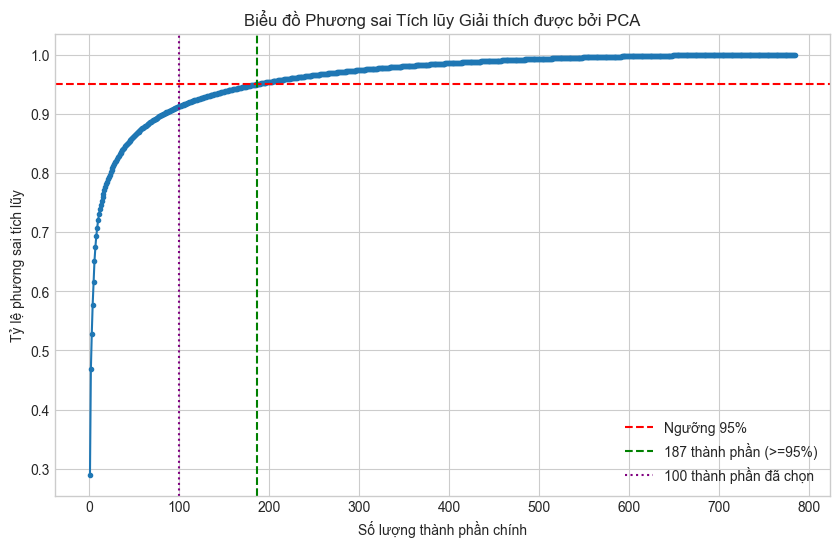

In [96]:
# Plot Cumulative Explained Variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='.', linestyle='-')
plt.xlabel('Số lượng thành phần chính')
plt.ylabel('Tỷ lệ phương sai tích lũy')
plt.title('Biểu đồ Phương sai Tích lũy Giải thích được bởi PCA')
plt.axhline(y=0.95, color='r', linestyle='--', label='Ngưỡng 95%')
plt.axvline(x=k_95, color='g', linestyle='--', label=f'{k_95} thành phần (>=95%)')
plt.axvline(x=N_COMPONENTS_PCA, color='purple', linestyle=':', label=f'{N_COMPONENTS_PCA} thành phần đã chọn')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [97]:
# Perform PCA for visualization (2 components)
print(f"\nPerforming PCA for {N_COMPONENTS_VIS} components visualization...")
t0 = time()
pca_vis = PCA(n_components=N_COMPONENTS_VIS, random_state=RANDOM_STATE)
X_train_pca_vis = pca_vis.fit_transform(X_train_scaled)
print(f"PCA for visualization done in {time() - t0:.3f}s")

# Perform PCA for classification comparison (N_COMPONENTS_PCA components)
print(f"\nPerforming PCA for {N_COMPONENTS_PCA} components classification...")
t0 = time()
pca_clf = PCA(n_components=N_COMPONENTS_PCA, random_state=RANDOM_STATE)
X_train_pca_clf = pca_clf.fit_transform(X_train_scaled)
# IMPORTANT: Transform test data using the *same* PCA model fitted on train data
X_test_pca_clf = pca_clf.transform(X_test_scaled) 
print(f"PCA for classification done in {time() - t0:.3f}s")
print(f"Shape of PCA-transformed training data: {X_train_pca_clf.shape}")
print(f"Shape of PCA-transformed test data: {X_test_pca_clf.shape}")


Performing PCA for 2 components visualization...
PCA for visualization done in 0.091s

Performing PCA for 100 components classification...
PCA for classification done in 0.100s
Shape of PCA-transformed training data: (60000, 100)
Shape of PCA-transformed test data: (10000, 100)


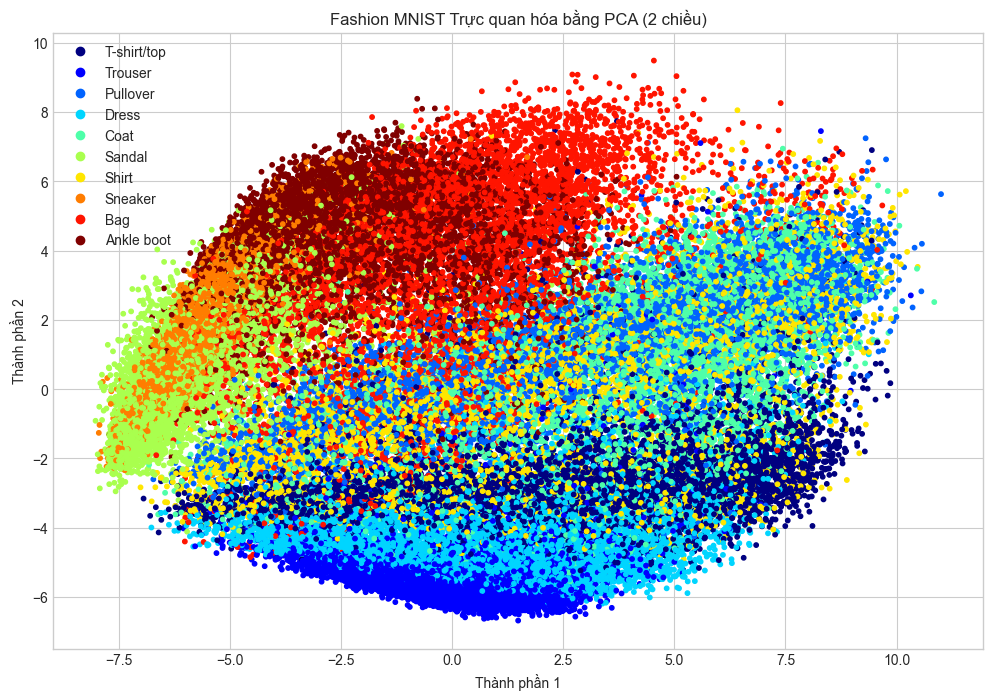

In [98]:
# --- Plotting Functions ---
def plot_dimension_reduction(X_reduced, y, title, n_components=2):
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap=plt.cm.get_cmap("jet", 10), s=10)
    plt.xlabel('Thành phần 1')
    plt.ylabel('Thành phần 2')
    plt.title(title)
    plt.legend(handles=scatter.legend_elements()[0], labels=CLASS_NAMES)
    plt.show()

def plot_dimension_reduction_3d(X_reduced, y, title):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, cmap=plt.cm.get_cmap("jet", 10), s=10)
    ax.set_xlabel('Thành phần 1')
    ax.set_ylabel('Thành phần 2')
    ax.set_zlabel('Thành phần 3')
    ax.set_title(title)
    ax.legend(handles=scatter.legend_elements()[0], labels=CLASS_NAMES)
    plt.show()

# Plot PCA 2D
plot_dimension_reduction(X_train_pca_vis, y_train, f'Fashion MNIST Trực quan hóa bằng PCA ({N_COMPONENTS_VIS} chiều)')

### 3.2. t-Distributed Stochastic Neighbor Embedding (t-SNE)

Performing t-SNE on 5000 samples...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.262s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.875440
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.759949
[t-SNE] KL divergence after 300 iterations: 2.167991
t-SNE done in 2.941s


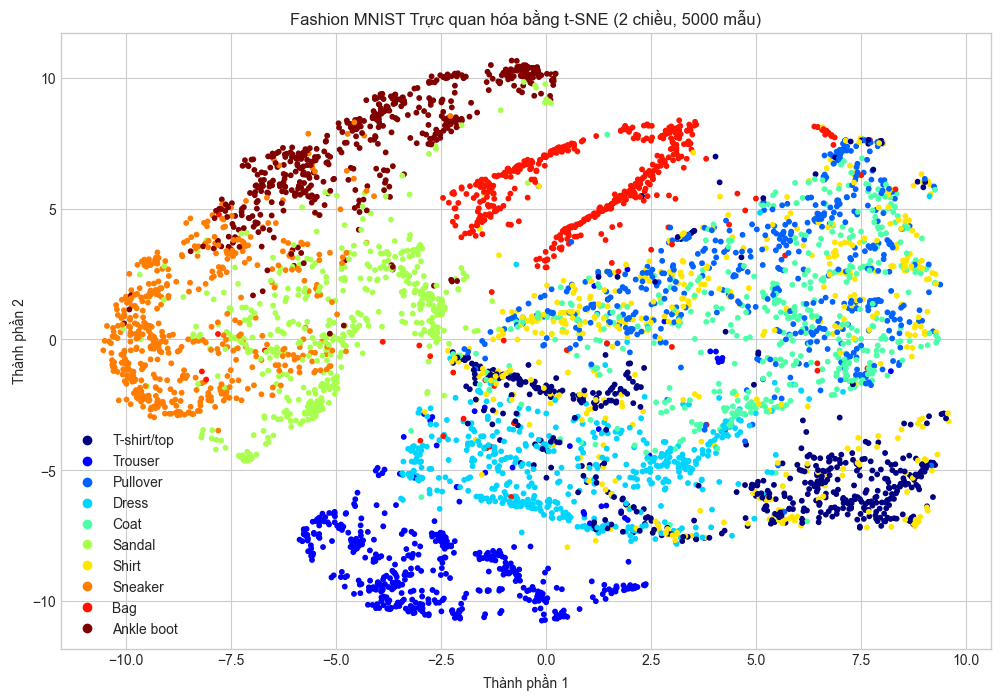

In [99]:
print(f"Performing t-SNE on {TSNE_N_SAMPLES} samples...")
t0 = time()

# Use a subset of data for t-SNE
subset_indices = np.random.choice(X_train_scaled.shape[0], TSNE_N_SAMPLES, replace=False)
X_subset = X_train_scaled[subset_indices]
y_subset = y_train[subset_indices]

tsne = TSNE(n_components=N_COMPONENTS_VIS, perplexity=TSNE_PERPLEXITY, random_state=RANDOM_STATE, n_iter=300, verbose=1)
X_train_tsne = tsne.fit_transform(X_subset)

print(f"t-SNE done in {time() - t0:.3f}s")

# Plot t-SNE 2D
plot_dimension_reduction(X_train_tsne, y_subset, f'Fashion MNIST Trực quan hóa bằng t-SNE ({N_COMPONENTS_VIS} chiều, {TSNE_N_SAMPLES} mẫu)')

### Trực quan hóa các Thành phần Chính (Eigenfashions)

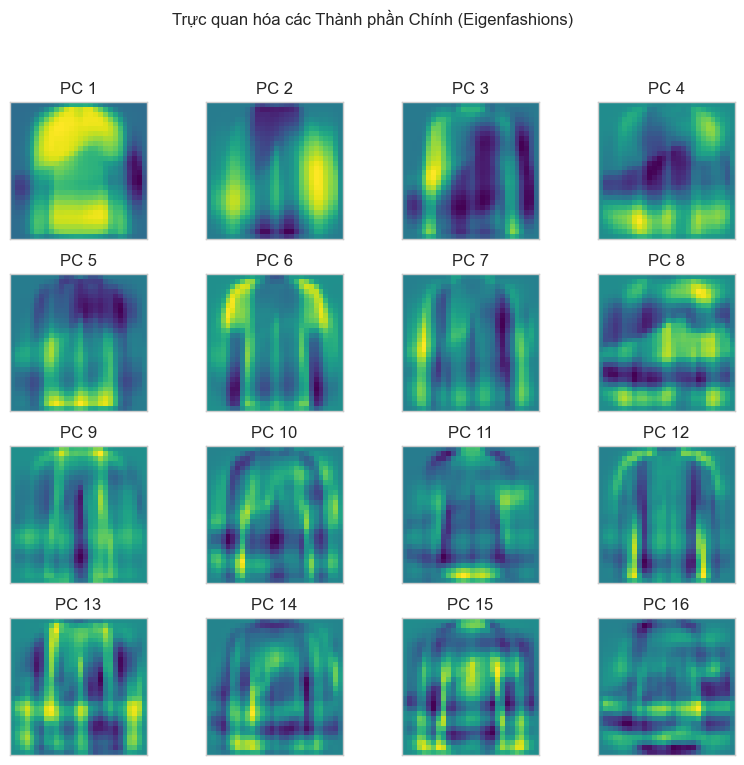

In [100]:
def plot_eigenfashions(pca_model, n_components_to_show=16):
    """Visualizes the first few principal components as images."""
    plt.figure(figsize=(8, 8))
    components = pca_model.components_[:n_components_to_show]
    n_rows = int(np.sqrt(n_components_to_show))
    n_cols = int(np.ceil(n_components_to_show / n_rows))

    for i, comp in enumerate(components):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(comp.reshape(28, 28), cmap='viridis') # Use a different cmap
        plt.title(f"PC {i+1}")
        plt.xticks(())
        plt.yticks(())
    plt.suptitle("Trực quan hóa các Thành phần Chính (Eigenfashions)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plot eigenfashions from the full PCA model
plot_eigenfashions(pca_full, n_components_to_show=16)

### Trực quan hóa các Cặp Thành phần Chính Khác nhau

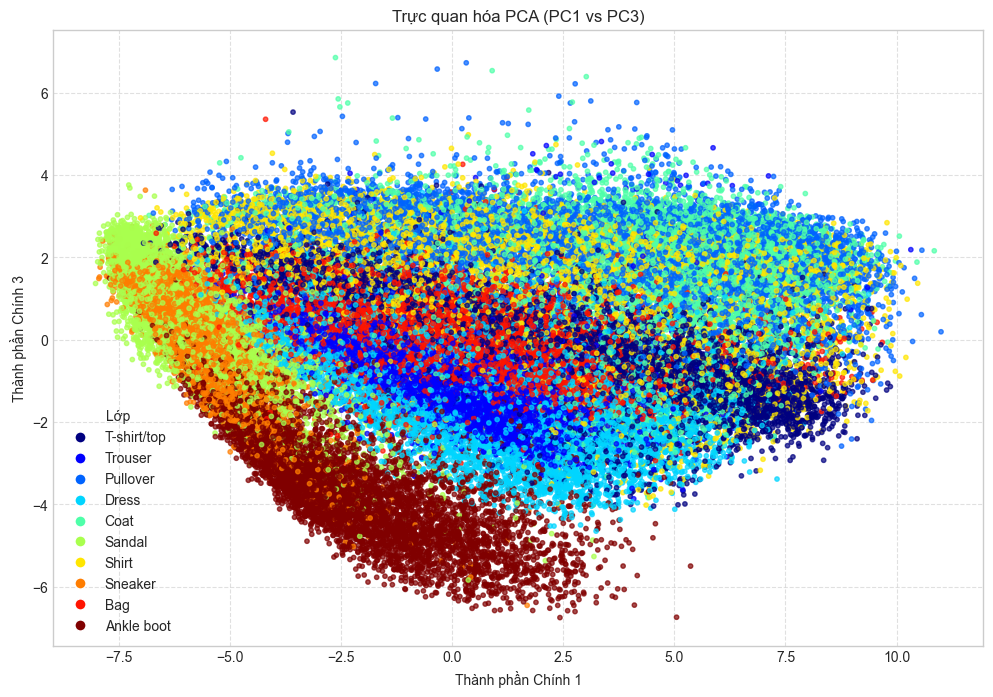

In [101]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_train_pca_clf[:, 0], X_train_pca_clf[:, 2], c=y_train, cmap=plt.cm.get_cmap("jet", 10), s=10, alpha=0.7)
plt.xlabel('Thành phần Chính 1')
plt.ylabel('Thành phần Chính 3')
plt.title('Trực quan hóa PCA (PC1 vs PC3)')
handles = [plt.Line2D([0], [0], marker='o', color='w', label=CLASS_NAMES[i],
                       markerfacecolor=plt.cm.get_cmap("jet", 10)(i/9.0), markersize=8) 
           for i in range(10)]
plt.legend(handles=handles, title="Lớp")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

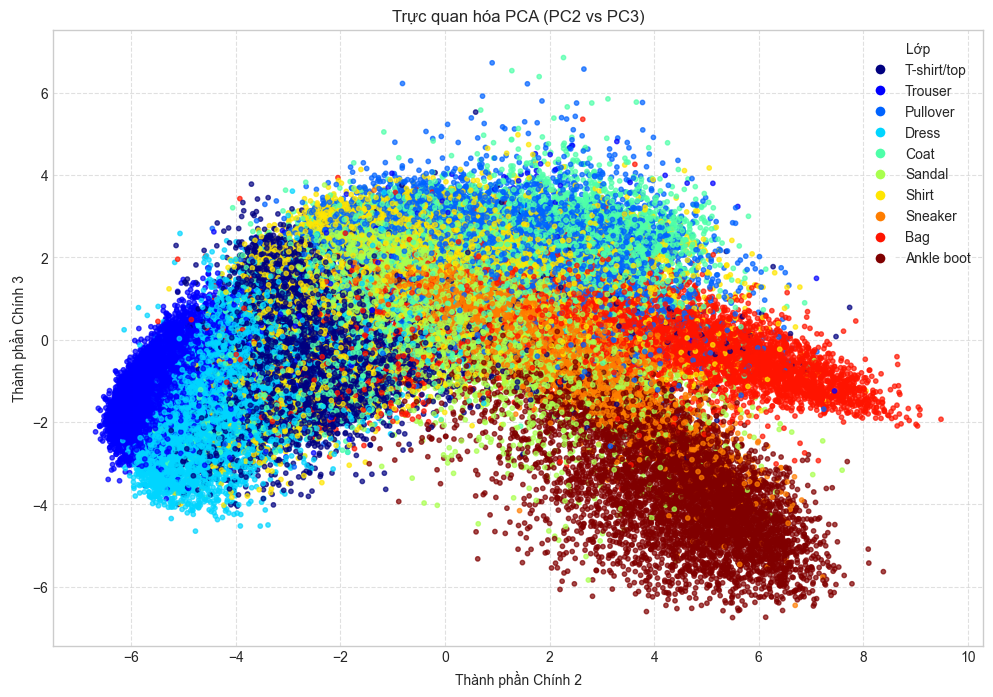

In [102]:
# Plot PC2 vs PC3
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_train_pca_clf[:, 1], X_train_pca_clf[:, 2], c=y_train, cmap=plt.cm.get_cmap("jet", 10), s=10, alpha=0.7)
plt.xlabel('Thành phần Chính 2')
plt.ylabel('Thành phần Chính 3')
plt.title('Trực quan hóa PCA (PC2 vs PC3)')
handles = [plt.Line2D([0], [0], marker='o', color='w', label=CLASS_NAMES[i],
                       markerfacecolor=plt.cm.get_cmap("jet", 10)(i/9.0), markersize=8)
           for i in range(10)]
plt.legend(handles=handles, title="Lớp")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### 3.3. So sánh PCA và t-SNE
- **PCA:** Nhanh hơn, giữ lại phương sai toàn cục, các cụm có thể bị chồng lấn nhiều hơn do chiếu tuyến tính. Tốt cho việc giảm chiều trước khi phân loại.
- **t-SNE:** Chậm hơn đáng kể, tập trung vào việc giữ cấu trúc lân cận cục bộ, thường tạo ra các cụm tách biệt rõ ràng hơn trên biểu đồ 2D. Rất tốt cho việc trực quan hóa nhưng không nên dùng để giảm chiều trước khi huấn luyện mô hình khác (không có hàm transform rõ ràng cho dữ liệu mới).
- Trên Fashion MNIST, t-SNE cho thấy khả năng phân tách các lớp tốt hơn PCA trên biểu đồ 2D, nhưng PCA vẫn cho thấy cấu trúc tổng thể của dữ liệu.

## IV. Phân cụm Dữ liệu (Unsupervised Learning)

In [103]:
# --- Clustering Helper Functions ---
def calculate_clustering_metrics(labels_true, labels_pred, data_for_silhouette=None):
    """Calculates common clustering evaluation metrics."""
    # Ensure labels_pred doesn't contain only noise (-1) if that's the only 'cluster'
    unique_labels = np.unique(labels_pred)
    if len(unique_labels) == 1 and unique_labels[0] == -1:
        print("Warning: Only noise points detected. Metrics like ARI, NMI, Homogeneity are undefined.")
        # Return default or NaN values
        return {
            'ARI': np.nan, 
            'NMI': np.nan, 
            'Homogeneity': np.nan,
            'Silhouette': np.nan
        }

    # Filter out noise points for metrics comparing to ground truth (ARI, NMI, Homogeneity)
    # Keep corresponding true labels
    if -1 in unique_labels:
        non_noise_mask = labels_pred != -1
        labels_true_filtered = labels_true[non_noise_mask]
        labels_pred_filtered = labels_pred[non_noise_mask]
        if len(labels_pred_filtered) == 0: # All points were noise
           print("Warning: All points classified as noise. Metrics like ARI, NMI, Homogeneity are undefined.")
           return {'ARI': np.nan, 'NMI': np.nan, 'Homogeneity': np.nan, 'Silhouette': np.nan}
    else:
        labels_true_filtered = labels_true
        labels_pred_filtered = labels_pred

    metrics_dict = {
        'ARI': adjusted_rand_score(labels_true_filtered, labels_pred_filtered),
        'NMI': normalized_mutual_info_score(labels_true_filtered, labels_pred_filtered),
        'Homogeneity': homogeneity_score(labels_true_filtered, labels_pred_filtered)
    }
    
    # Silhouette Score requires data and needs at least 2 clusters (excluding noise)
    unique_clusters_no_noise = np.unique(labels_pred_filtered)
    if data_for_silhouette is not None and len(unique_clusters_no_noise) > 1:
        try:
            # Use a sample if data is too large
            sample_size = 5000
            # Filter data_for_silhouette to include only non-noise points for Silhouette calculation
            data_silhouette_filtered = data_for_silhouette[non_noise_mask] if -1 in unique_labels else data_for_silhouette
            
            if data_silhouette_filtered.shape[0] > sample_size:
                indices = np.random.choice(data_silhouette_filtered.shape[0], sample_size, replace=False)
                # Use filtered labels corresponding to the sampled data
                sampled_labels_pred = labels_pred_filtered[indices] 
                # Ensure sampled labels still have >1 cluster
                if len(np.unique(sampled_labels_pred)) > 1:
                     silhouette = silhouette_score(data_silhouette_filtered[indices], sampled_labels_pred)
                else:
                     silhouette = np.nan # Not enough clusters in sample
                     print("Warning: Sample for Silhouette score resulted in <= 1 cluster.")
            elif data_silhouette_filtered.shape[0] > 1 : # Need at least 2 samples
                 silhouette = silhouette_score(data_silhouette_filtered, labels_pred_filtered)
            else:
                 silhouette = np.nan # Not enough samples overall
                 print("Warning: Not enough non-noise samples to calculate Silhouette score.")

            metrics_dict['Silhouette'] = silhouette
        except ValueError as ve:
             # Catch specific ValueError often related to cluster numbers
             print(f"Could not calculate Silhouette Score: {ve}")
             metrics_dict['Silhouette'] = np.nan
        except Exception as e:
             print(f"Could not calculate Silhouette Score: {e}")
             metrics_dict['Silhouette'] = np.nan
    else:
        metrics_dict['Silhouette'] = np.nan # '<=1 cluster or no data'

    return metrics_dict


def print_clustering_results(model_name, labels_true, labels_pred, data_for_silhouette=None):
    """Prints clustering metrics."""
    print(f"\n--- Clustering Results: {model_name} ---")
    # Count noise points first if applicable (DBSCAN)
    n_noise = 0
    n_clusters_found = len(set(labels_pred) - {-1}) # Exclude noise label -1
    if -1 in np.unique(labels_pred):
         n_noise = list(labels_pred).count(-1)
         print(f"Number of clusters found: {n_clusters_found}")
         print(f"Noise points: {n_noise} ({n_noise*100.0/len(labels_pred):.2f}%)")
    else:
         print(f"Number of clusters found: {n_clusters_found}")

    metrics_res = calculate_clustering_metrics(labels_true, labels_pred, data_for_silhouette)
    for metric, value in metrics_res.items():
        if isinstance(value, float) and not np.isnan(value):
            print(f"{metric}: {value:.4f}")
        else:
            print(f"{metric}: {value}") # Print NaN or N/A as is

# ADDED: Function to plot clustering results
def plot_clustering_results_2d(X_reduced_vis, cluster_labels, title, algorithm_name):
    """Plots 2D clustering results, coloring by cluster ID."""
    plt.figure(figsize=(12, 8))
    
    unique_labels = sorted(list(np.unique(cluster_labels)))
    n_clusters_ = len(unique_labels) - (1 if -1 in unique_labels else 0) # Exclude noise if present
    
    # Create a colormap: Use 'jet' for clusters, black for noise
    colors = plt.cm.get_cmap("jet", n_clusters_)
    custom_cmap_list = [colors(i) for i in range(n_clusters_)]
    label_map = {label: i for i, label in enumerate(unique_labels) if label != -1}

    # Assign colors based on cluster ID, noise is black
    point_colors = []
    noise_present = False
    for label in cluster_labels:
        if label == -1:
            point_colors.append((0, 0, 0, 1)) # Black for noise
            noise_present = True
        else:
            point_colors.append(custom_cmap_list[label_map[label]])

    scatter = plt.scatter(X_reduced_vis[:, 0], X_reduced_vis[:, 1], c=point_colors, s=10, alpha=0.7)
    
    plt.xlabel('Thành phần PCA 1')
    plt.ylabel('Thành phần PCA 2')
    plt.title(title)

    # Create legend (optional, can be crowded)
    handles = []
    if n_clusters_ > 0 :
         cluster_indices = sorted(label_map.keys())
         handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'Cụm {i}',
                           markerfacecolor=custom_cmap_list[label_map[i]], markersize=8)
                   for i in cluster_indices[:15]] # Limit legend entries if too many clusters
    if noise_present:
        handles.append(plt.Line2D([0], [0], marker='o', color='w', label='Nhiễu (-1)',
                       markerfacecolor='black', markersize=8))
        
    if handles: # Only show legend if there's something to show
       plt.legend(handles=handles, title=f"{algorithm_name} Clusters", loc='best', fontsize='small')

    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

### 4.1. K-Means

In [104]:
print("Running K-Means...")

# K-Means on Original Scaled Data
t0 = time()
kmeans_orig = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, n_init=10) # n_init='auto' or 10
kmeans_orig.fit(X_train_scaled)
labels_kmeans_orig = kmeans_orig.labels_
print(f"K-Means on original data done in {time() - t0:.3f}s")
print(f"Inertia (WCSS) on original data: {kmeans_orig.inertia_:.2f}")
print_clustering_results("K-Means (Original Data)", y_train, labels_kmeans_orig, X_train_scaled)

# K-Means on PCA Reduced Data
t0 = time()
kmeans_pca = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, n_init=10)
kmeans_pca.fit(X_train_pca_clf) # Use data reduced to N_COMPONENTS_PCA
labels_kmeans_pca = kmeans_pca.labels_
print(f"\nK-Means on PCA ({N_COMPONENTS_PCA} comps) data done in {time() - t0:.3f}s")
print(f"Inertia (WCSS) on PCA data: {kmeans_pca.inertia_:.2f}")
print_clustering_results(f"K-Means (PCA {N_COMPONENTS_PCA} comps)", y_train, labels_kmeans_pca, X_train_pca_clf)

# Elbow Method Plot (Example on Original Data)
print("\nCalculating Elbow Method for K-Means (Original Data)...")
inertias = []
k_range = range(2, 16) # Check a wider range
for k in k_range:
    kmeans_elbow = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    kmeans_elbow.fit(X_train_scaled) # Fitting on potentially large data, might be slow
    inertias.append(kmeans_elbow.inertia_)
    print(f"Finished K={k}, Inertia={kmeans_elbow.inertia_:.2f}")

Running K-Means...
K-Means on original data done in 10.373s
Inertia (WCSS) on original data: 1906652.75

--- Clustering Results: K-Means (Original Data) ---
Number of clusters found: 10
ARI: 0.3479
NMI: 0.5118
Homogeneity: 0.5004
Silhouette: 0.15499813854694366

K-Means on PCA (100 comps) data done in 1.192s
Inertia (WCSS) on PCA data: 1548091.00

--- Clustering Results: K-Means (PCA 100 comps) ---
Number of clusters found: 10
ARI: 0.3480
NMI: 0.5119
Homogeneity: 0.5005
Silhouette: 0.18236203491687775

Calculating Elbow Method for K-Means (Original Data)...
Finished K=2, Inertia=3233032.50
Finished K=3, Inertia=2766659.00
Finished K=4, Inertia=2505224.50
Finished K=5, Inertia=2352604.50
Finished K=6, Inertia=2202641.50
Finished K=7, Inertia=2099375.00
Finished K=8, Inertia=2027698.88
Finished K=9, Inertia=1963210.00
Finished K=10, Inertia=1906652.75
Finished K=11, Inertia=1858756.25
Finished K=12, Inertia=1810273.25
Finished K=13, Inertia=1770239.75
Finished K=14, Inertia=1737044.75
Fi

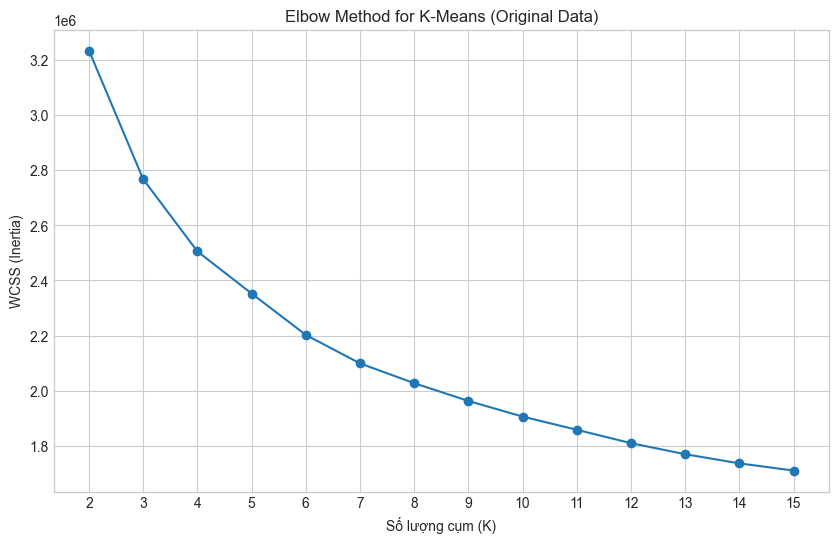

In [105]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method for K-Means (Original Data)')
plt.xlabel('Số lượng cụm (K)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

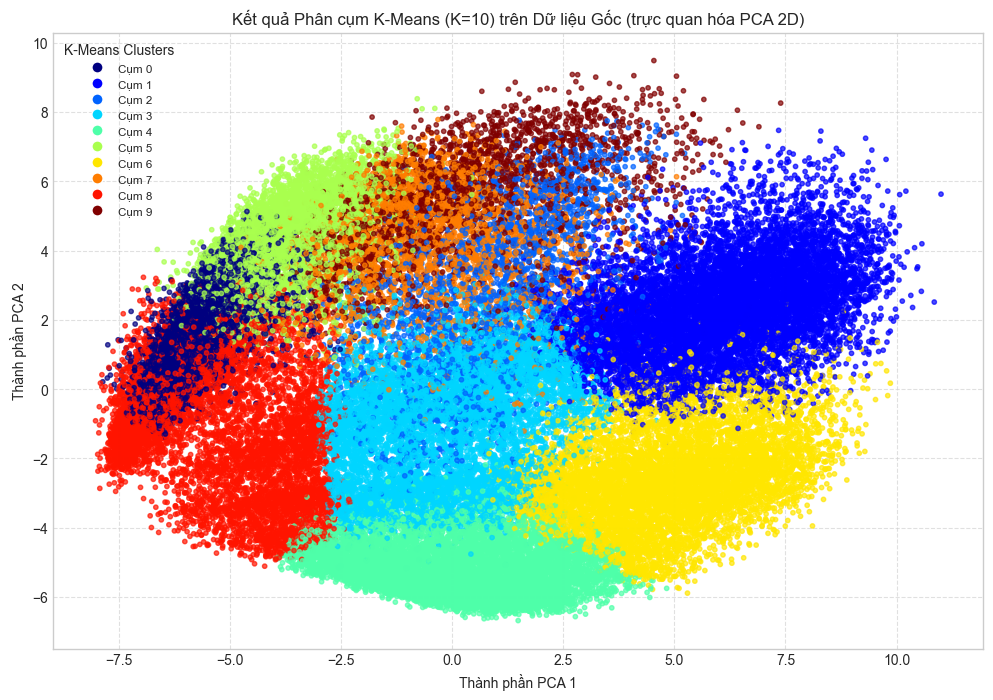

In [106]:
# Visualize K-Means Clustering Results
plot_clustering_results_2d(X_train_pca_vis, labels_kmeans_orig, 
                           'Kết quả Phân cụm K-Means (K=10) trên Dữ liệu Gốc (trực quan hóa PCA 2D)',
                           'K-Means')

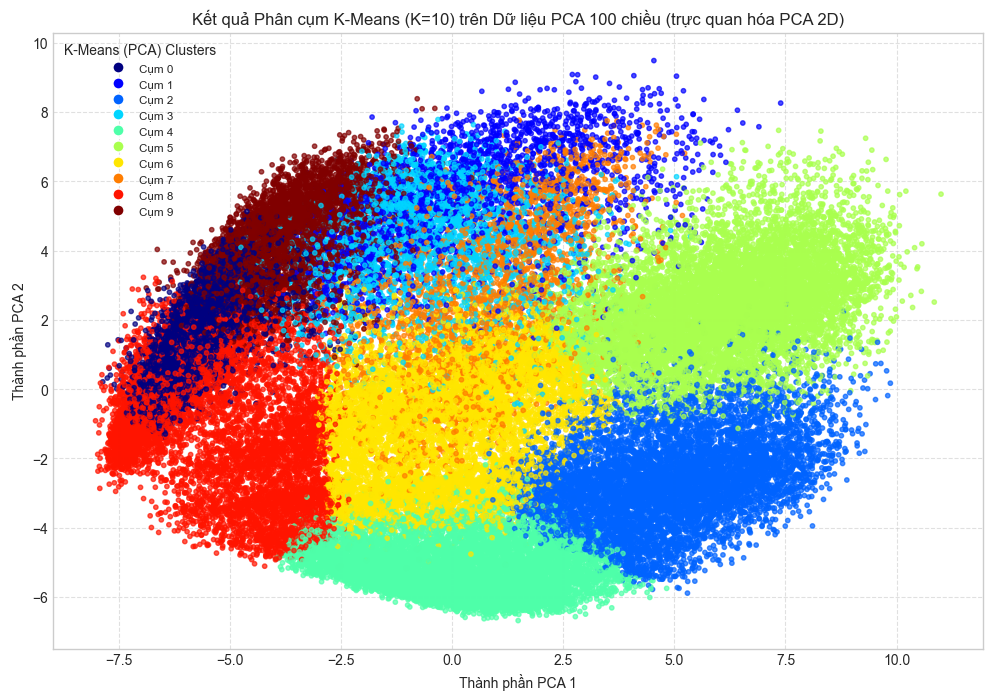

In [107]:
plot_clustering_results_2d(X_train_pca_vis, labels_kmeans_pca, 
                           f'Kết quả Phân cụm K-Means (K=10) trên Dữ liệu PCA {N_COMPONENTS_PCA} chiều (trực quan hóa PCA 2D)',
                           'K-Means (PCA)')

### Trực quan hóa Tâm cụm K-Means

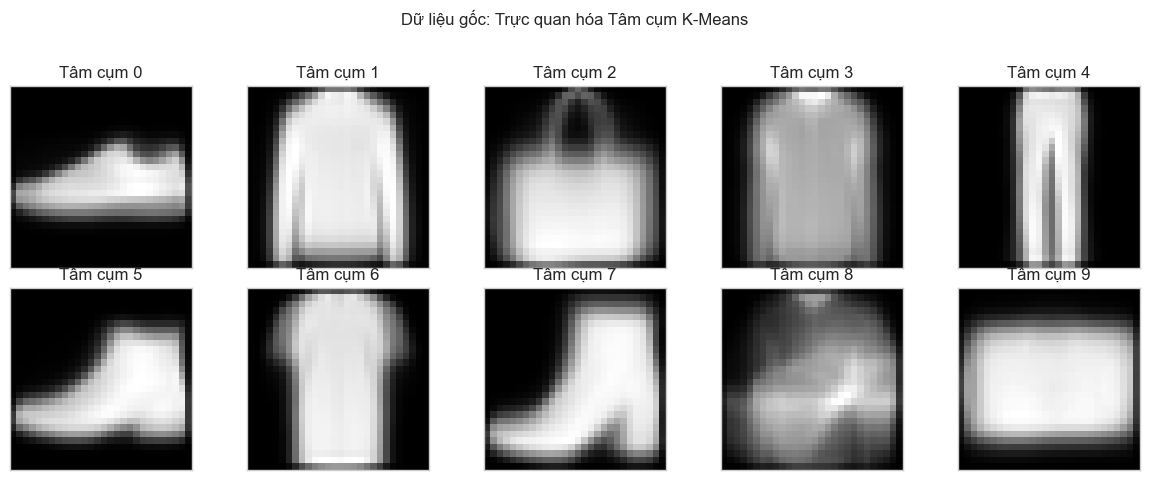

In [108]:
def plot_kmeans_centroids(kmeans_model, n_clusters, title_prefix=""):
    """Visualizes K-Means centroids as images."""
    try:
        centroids = kmeans_model.cluster_centers_
        # Data was scaled to [0,1], so centroids are likely in that range
        # No need to rescale unless they were inverse_transformed from PCA space
        
        plt.figure(figsize=(12, 5 if n_clusters > 5 else 3 ))
        n_rows = 2 if n_clusters > 5 else 1
        n_cols = int(np.ceil(n_clusters / n_rows))
        
        for i, center in enumerate(centroids):
             # Check if number of subplots exceeds available slots
            if i >= n_rows * n_cols:
                break 
            plt.subplot(n_rows, n_cols, i + 1)
            
            # Reshape based on original dimension (784) or PCA dimension (N_COMPONENTS_PCA)
            if center.shape[0] == 784:
                 img_shape = (28, 28)
                 cmap = 'gray'
            elif center.shape[0] == N_COMPONENTS_PCA:
                 # Cannot directly reshape PCA components into meaningful 28x28 image
                 # Need to inverse_transform, requires the PCA object used for fitting kmeans_pca
                 # Assuming pca_clf is the correct object
                 try:
                     center_original_space = pca_clf.inverse_transform(center.reshape(1, -1))
                     center = center_original_space.flatten() # Use the reconstructed image
                     img_shape = (28, 28)
                     cmap = 'viridis' # Use different cmap to indicate reconstructed
                 except Exception as e:
                     print(f"Could not inverse transform PCA centroid {i}: {e}. Skipping visualization.")
                     plt.title(f"Tâm cụm {i}\n(PCA space)")
                     plt.xticks(())
                     plt.yticks(())
                     continue # Skip imshow for this centroid
            else:
                 print(f"Warning: Centroid {i} has unexpected shape {center.shape}. Cannot reshape.")
                 plt.title(f"Tâm cụm {i}\n(Unknown shape)")
                 plt.xticks(())
                 plt.yticks(())
                 continue # Skip imshow
                 
            plt.imshow(center.reshape(img_shape), cmap=cmap)
            plt.title(f"Tâm cụm {i}")
            plt.xticks(())
            plt.yticks(())
            
        plt.suptitle(f"{title_prefix}Trực quan hóa Tâm cụm K-Means")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    except AttributeError:
        print("Error: kmeans_model does not have 'cluster_centers_'. Was it fitted?")
    except Exception as e:
        print(f"An error occurred during centroid visualization: {e}")


# Plot centroids from K-Means on original scaled data
plot_kmeans_centroids(kmeans_orig, N_CLUSTERS, title_prefix="Dữ liệu gốc: ")

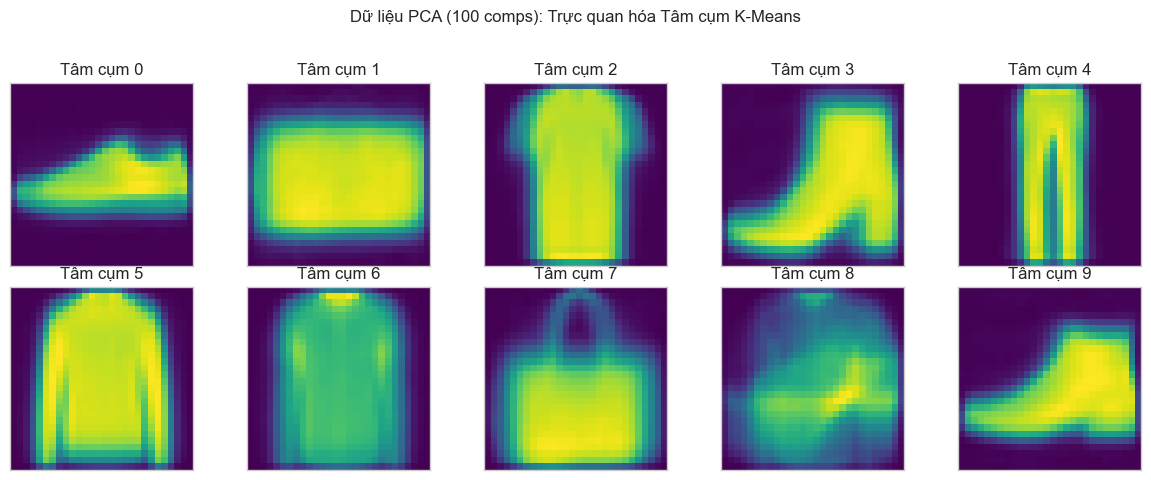

In [109]:
# Plot centroids from K-Means on PCA data (will attempt inverse transform)
plot_kmeans_centroids(kmeans_pca, N_CLUSTERS, title_prefix=f"Dữ liệu PCA ({N_COMPONENTS_PCA} comps): ")

**Nhận xét K-Means:**
- Elbow plot không cho thấy điểm "khuỷu tay" rõ ràng, cho thấy K=10 có thể không phải là cấu trúc tự nhiên tối ưu.
- Metrics (ARI, NMI) cho thấy K-Means có khả năng tìm thấy một số cấu trúc liên quan đến nhãn gốc, nhưng không hoàn hảo. Silhouette score trung bình cho thấy các cụm có thể bị chồng lấn hoặc không dày đặc.
- Chạy trên dữ liệu PCA (100 chiều) cho kết quả metrics tương tự hoặc hơi thấp hơn so với dữ liệu gốc, nhưng nhanh hơn đáng kể và giảm inertia.

### 4.2. DBSCAN

In [110]:
print("Running DBSCAN...")
eps_dbscan = 3 
min_samples_dbscan = 5

# DBSCAN on Original Scaled Data
print("Running DBSCAN on PCA data first due to potential performance issues...")
t0 = time()
dbscan_pca = DBSCAN(eps=eps_dbscan, min_samples=min_samples_dbscan, n_jobs=-1) # Use all cores
labels_dbscan_pca = dbscan_pca.fit_predict(X_train_pca_clf) # Use PCA data
print(f"DBSCAN on PCA ({N_COMPONENTS_PCA} comps) data done in {time() - t0:.3f}s")
print_clustering_results(f"DBSCAN (PCA {N_COMPONENTS_PCA} comps)", y_train, labels_dbscan_pca, X_train_pca_clf)

# DBSCAN on Original Scaled Data
print("\nRunning DBSCAN on Original Data")
t0 = time()
dbscan_orig = DBSCAN(eps=eps_dbscan, min_samples=min_samples_dbscan, n_jobs=-1) 
labels_dbscan_orig = dbscan_orig.fit_predict(X_train_scaled)
print(f"DBSCAN on original data done in {time() - t0:.3f}s")
print_clustering_results("DBSCAN (Original Data)", y_train, labels_dbscan_orig, X_train_scaled)

Running DBSCAN...
Running DBSCAN on PCA data first due to potential performance issues...
DBSCAN on PCA (100 comps) data done in 2.066s

--- Clustering Results: DBSCAN (PCA 100 comps) ---
Number of clusters found: 67
Noise points: 18510 (30.85%)
ARI: 0.0028
NMI: 0.0356
Homogeneity: 0.0190
Silhouette: -0.3347611427307129

Running DBSCAN on Original Data
DBSCAN on original data done in 15.883s

--- Clustering Results: DBSCAN (Original Data) ---
Number of clusters found: 101
Noise points: 44930 (74.88%)
ARI: 0.0607
NMI: 0.2288
Homogeneity: 0.1544
Silhouette: -0.360185444355011


**Nhận xét DBSCAN:**
- Với các tham số `eps=3, min_samples=5`, DBSCAN dường như không hoạt động tốt trên dữ liệu này (kể cả trên PCA), metrics (ARI, NMI) rất thấp và có thể phần lớn điểm bị coi là nhiễu (noise).
- Điều này cho thấy cấu trúc mật độ của Fashion MNIST có thể không phù hợp với giả định của DBSCAN (các vùng dày đặc cách biệt bởi vùng thưa) hoặc cần tinh chỉnh tham số `eps` và `min_samples` kỹ lưỡng hơn.

## V. Phân loại Dữ liệu (Supervised Learning)

In [111]:
# --- Classification Helper Function ---
def evaluate_classifier(model_name, model, X_test_data, y_test_data, train_time=None, class_names=CLASS_NAMES):
    """Evaluates a classifier and prints results."""
    print(f"\n--- Evaluating Classifier: {model_name} ---")
    if train_time is not None:
        print(f"Training time: {train_time:.3f}s")
        
    t0 = time()
    try:
        y_pred = model.predict(X_test_data)
    except Exception as e:
        print(f"Error during prediction: {e}")
        return 0.0 # Return 0 accuracy on error
        
    predict_time = time() - t0
    print(f"Prediction time: {predict_time:.3f}s")

    # Ensure y_pred and y_test_data are compatible (e.g., not one-hot)
    if y_test_data.ndim > 1 and y_test_data.shape[1] > 1:
        y_test_data_classes = np.argmax(y_test_data, axis=1)
    else:
        y_test_data_classes = y_test_data
        
    # Same for y_pred if model outputs probabilities (like CNN before argmax)
    if y_pred.ndim > 1 and y_pred.shape[1] > 1:
         y_pred_classes = np.argmax(y_pred, axis=1)
    else:
         y_pred_classes = y_pred

    try:
        accuracy = accuracy_score(y_test_data_classes, y_pred_classes)
        print(f"Accuracy: {accuracy:.4f}")
        print("Classification Report:")
        print(classification_report(y_test_data_classes, y_pred_classes, target_names=class_names))
        
        # Plot Confusion Matrix
        cm = confusion_matrix(y_test_data_classes, y_pred_classes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
        return accuracy # Return accuracy for summary
    except ValueError as ve:
        print(f"Error during metric calculation or plotting: {ve}")
        print("Check if labels and predictions are valid.")
        return 0.0
    except Exception as e:
        print(f"An unexpected error occurred during evaluation: {e}")
        return 0.0


# Dictionary to store results
classification_results = {}

### 5.1. Naive Bayes


Training Gaussian Naive Bayes...

--- Evaluating Classifier: Gaussian NB (Original Data) ---
Training time: 0.121s
Prediction time: 0.205s
Accuracy: 0.5856
Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.81      0.59      0.68      1000
     Trouser       0.64      0.94      0.76      1000
    Pullover       0.59      0.32      0.42      1000
       Dress       0.44      0.55      0.49      1000
        Coat       0.38      0.78      0.51      1000
      Sandal       0.93      0.28      0.43      1000
       Shirt       0.32      0.04      0.07      1000
     Sneaker       0.51      0.99      0.67      1000
         Bag       0.83      0.71      0.77      1000
  Ankle boot       0.91      0.67      0.77      1000

    accuracy                           0.59     10000
   macro avg       0.64      0.59      0.56     10000
weighted avg       0.64      0.59      0.56     10000



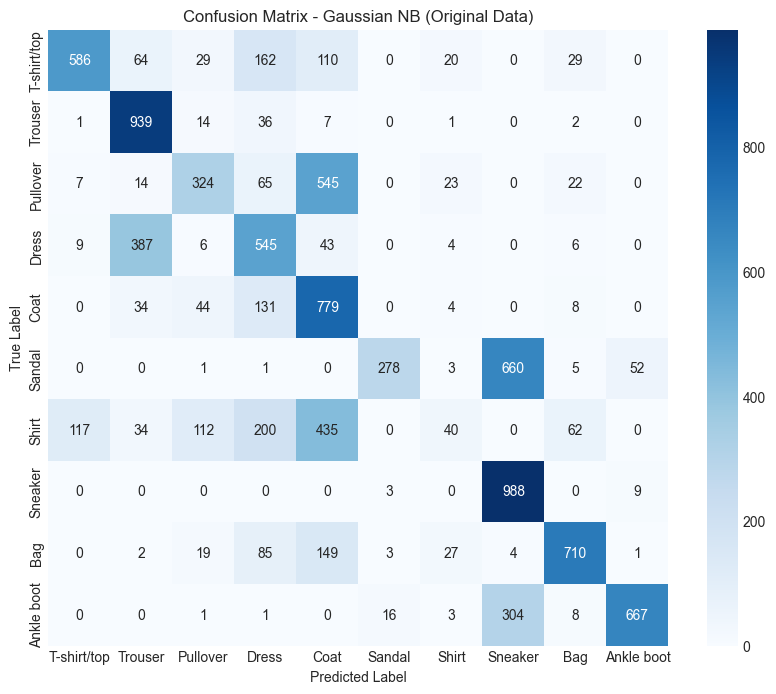


--- Evaluating Classifier: Gaussian NB (PCA 100 comps) ---
Training time: 0.019s
Prediction time: 0.026s
Accuracy: 0.7582
Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.74      0.74      0.74      1000
     Trouser       0.99      0.89      0.94      1000
    Pullover       0.68      0.61      0.64      1000
       Dress       0.79      0.78      0.79      1000
        Coat       0.73      0.66      0.69      1000
      Sandal       0.86      0.75      0.80      1000
       Shirt       0.48      0.52      0.50      1000
     Sneaker       0.78      0.88      0.83      1000
         Bag       0.68      0.87      0.76      1000
  Ankle boot       0.91      0.89      0.90      1000

    accuracy                           0.76     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.77      0.76      0.76     10000



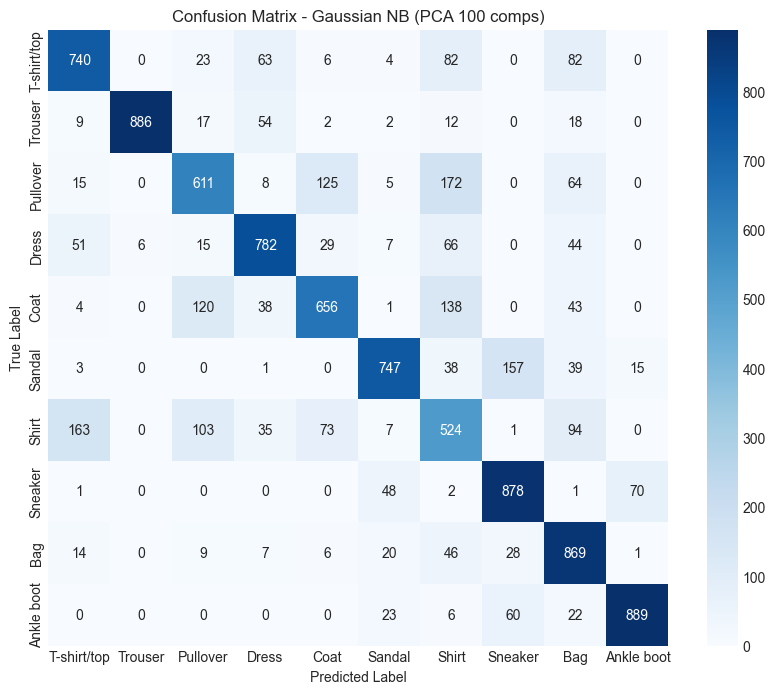

In [112]:
# --- Gaussian Naive Bayes ---
print("\nTraining Gaussian Naive Bayes...")
# On Original Scaled Data
t0 = time()
gnb_orig = GaussianNB()
gnb_orig.fit(X_train_scaled, y_train)
train_time_gnb_orig = time() - t0
acc_gnb_orig = evaluate_classifier("Gaussian NB (Original Data)", gnb_orig, X_test_scaled, y_test, train_time_gnb_orig)
classification_results["GNB_Original"] = acc_gnb_orig

# On PCA Data
t0 = time()
gnb_pca = GaussianNB()
gnb_pca.fit(X_train_pca_clf, y_train)
train_time_gnb_pca = time() - t0
acc_gnb_pca = evaluate_classifier(f"Gaussian NB (PCA {N_COMPONENTS_PCA} comps)", gnb_pca, X_test_pca_clf, y_test, train_time_gnb_pca)
classification_results["GNB_PCA"] = acc_gnb_pca


Training Multinomial Naive Bayes...

--- Evaluating Classifier: Multinomial NB (Raw Data) ---
Training time: 0.088s
Prediction time: 0.009s
Accuracy: 0.6554
Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.73      0.78      0.75      1000
     Trouser       0.99      0.87      0.93      1000
    Pullover       0.59      0.57      0.58      1000
       Dress       0.66      0.87      0.75      1000
        Coat       0.44      0.60      0.51      1000
      Sandal       0.66      0.14      0.23      1000
       Shirt       0.32      0.16      0.22      1000
     Sneaker       0.60      0.92      0.73      1000
         Bag       0.87      0.80      0.84      1000
  Ankle boot       0.68      0.84      0.75      1000

    accuracy                           0.66     10000
   macro avg       0.65      0.66      0.63     10000
weighted avg       0.65      0.66      0.63     10000



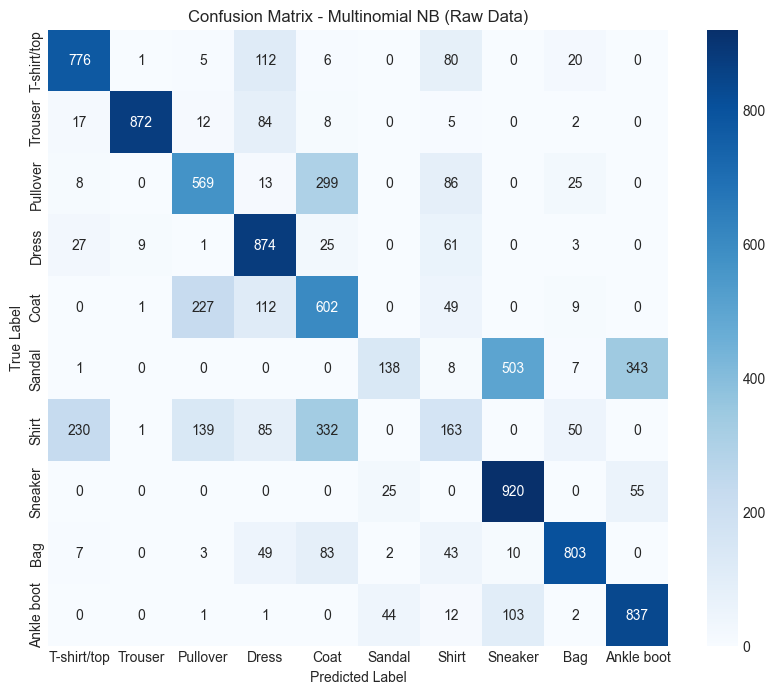

In [113]:
# --- Multinomial Naive Bayes ---
print("\nTraining Multinomial Naive Bayes...")
# On Original Raw Data (0-255)
t0 = time()
mnb_orig = MultinomialNB()
mnb_orig.fit(X_train_raw, y_train)
train_time_mnb_orig = time() - t0
acc_mnb_orig = evaluate_classifier("Multinomial NB (Raw Data)", mnb_orig, X_test_raw, y_test, train_time_mnb_orig)
classification_results["MNB_Original"] = acc_mnb_orig

**Nhận xét Naive Bayes:**
- Gaussian NB cho kết quả khá thấp (Accuracy ~58.6% trên dữ liệu gốc, ~75.8% trên PCA), cho thấy giả định độc lập và phân phối Gaussian cho các pixel không phù hợp lắm. Giảm chiều bằng PCA cải thiện đáng kể, có thể do các thành phần chính gần với phân phối Gaussian hơn.
- Multinomial NB (trên dữ liệu pixel gốc 0-255) hoạt động tốt hơn đáng kể (Accuracy ~65.5%), gợi ý rằng việc xem xét giá trị pixel như các đặc trưng rời rạc có thể hiệu quả hơn giả định Gaussian.

### 5.2. Support Vector Machine (SVM)


Training SVM (Linear Kernel)...



--- Evaluating Classifier: SVM Linear (Original Data, C=1.0) ---
Training time: 242.339s
Prediction time: 20.666s
Accuracy: 0.8463
Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.75      0.81      0.78      1000
     Trouser       0.97      0.96      0.97      1000
    Pullover       0.73      0.77      0.75      1000
       Dress       0.85      0.84      0.85      1000
        Coat       0.76      0.77      0.77      1000
      Sandal       0.93      0.94      0.93      1000
       Shirt       0.63      0.56      0.59      1000
     Sneaker       0.92      0.93      0.93      1000
         Bag       0.95      0.93      0.94      1000
  Ankle boot       0.95      0.94      0.95      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



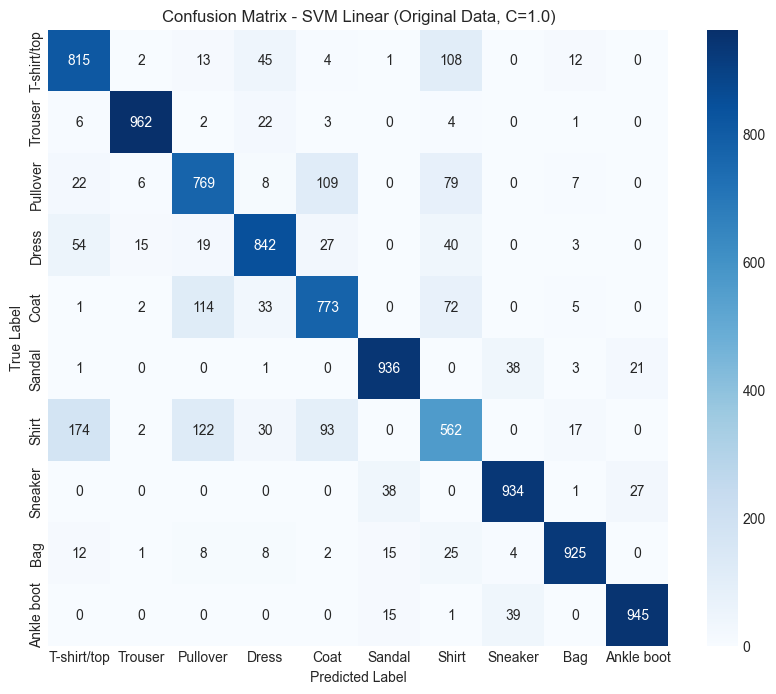


--- Evaluating Classifier: SVM Linear (PCA 100 comps, C=1.0) ---
Training time: 24.379s
Prediction time: 4.503s
Accuracy: 0.8497
Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.78      0.83      0.80      1000
     Trouser       0.97      0.96      0.96      1000
    Pullover       0.74      0.76      0.75      1000
       Dress       0.84      0.87      0.86      1000
        Coat       0.75      0.76      0.76      1000
      Sandal       0.94      0.93      0.94      1000
       Shirt       0.64      0.56      0.60      1000
     Sneaker       0.91      0.94      0.92      1000
         Bag       0.95      0.95      0.95      1000
  Ankle boot       0.96      0.94      0.95      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



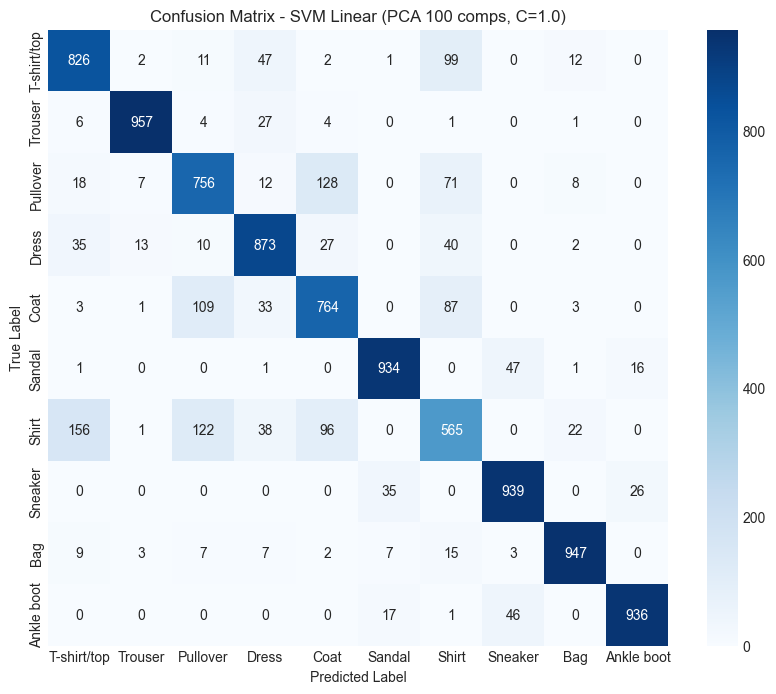

In [114]:
# --- SVM Linear ---
print("\nTraining SVM (Linear Kernel)...")
# On Original Data
t0 = time()
svm_linear = SVC(kernel='linear', random_state=RANDOM_STATE, C=1.0, cache_size=1000) # Default C
svm_linear.fit(X_train_scaled, y_train)
train_time_svm_linear = time() - t0
acc_svm_linear = evaluate_classifier("SVM Linear (Original Data, C=1.0)", svm_linear, X_test_scaled, y_test, train_time_svm_linear)
classification_results["SVM_Linear_Original"] = acc_svm_linear

# On PCA Data
t0 = time()
svm_linear_pca = SVC(kernel='linear', random_state=RANDOM_STATE, C=1.0, cache_size=1000)
svm_linear_pca.fit(X_train_pca_clf, y_train)
train_time_svm_linear_pca = time() - t0
acc_svm_linear_pca = evaluate_classifier(f"SVM Linear (PCA {N_COMPONENTS_PCA} comps, C=1.0)", svm_linear_pca, X_test_pca_clf, y_test, train_time_svm_linear_pca)
classification_results["SVM_Linear_PCA"] = acc_svm_linear_pca


Training SVM (RBF Kernel, Default Params)...

--- Evaluating Classifier: SVM RBF (Original Data, Default) ---
Training time: 212.745s
Prediction time: 49.255s
Accuracy: 0.8829
Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.86      0.84      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.79      0.82      0.80      1000
       Dress       0.87      0.89      0.88      1000
        Coat       0.81      0.81      0.81      1000
      Sandal       0.96      0.95      0.96      1000
       Shirt       0.72      0.66      0.69      1000
     Sneaker       0.93      0.95      0.94      1000
         Bag       0.97      0.98      0.97      1000
  Ankle boot       0.96      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



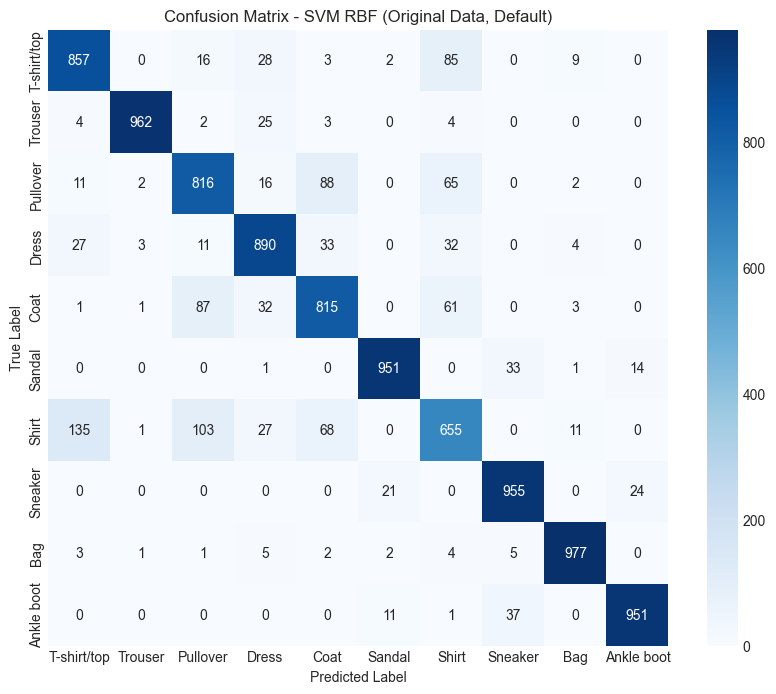


--- Evaluating Classifier: SVM RBF (PCA 100 comps, Default) ---
Training time: 16.233s
Prediction time: 14.504s
Accuracy: 0.8847
Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.86      0.85      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.80      0.81      0.80      1000
       Dress       0.87      0.90      0.88      1000
        Coat       0.80      0.82      0.81      1000
      Sandal       0.97      0.95      0.96      1000
       Shirt       0.71      0.66      0.69      1000
     Sneaker       0.92      0.96      0.94      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.97      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



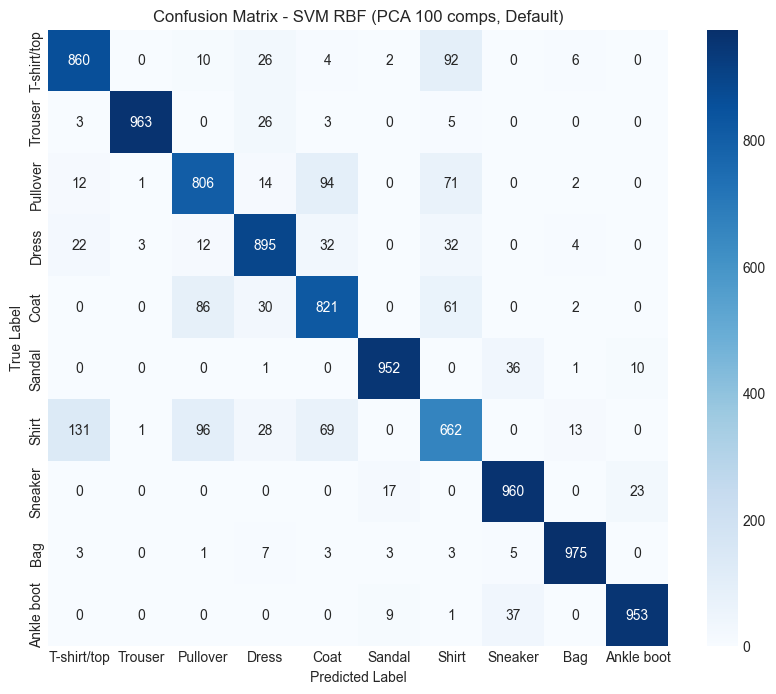

In [115]:
# --- SVM RBF (Default Parameters) ---
print("\nTraining SVM (RBF Kernel, Default Params)...")
# On Original Data
t0 = time()
svm_rbf_default = SVC(kernel='rbf', random_state=RANDOM_STATE, C=1.0, gamma='scale', cache_size=1000) # Default C=1.0, gamma='scale'
svm_rbf_default.fit(X_train_scaled, y_train)
train_time_svm_rbf_default = time() - t0
acc_svm_rbf_default = evaluate_classifier("SVM RBF (Original Data, Default)", svm_rbf_default, X_test_scaled, y_test, train_time_svm_rbf_default)
classification_results["SVM_RBF_Default_Original"] = acc_svm_rbf_default

# On PCA Data
t0 = time()
svm_rbf_default_pca = SVC(kernel='rbf', random_state=RANDOM_STATE, C=1.0, gamma='scale', cache_size=1000)
svm_rbf_default_pca.fit(X_train_pca_clf, y_train)
train_time_svm_rbf_default_pca = time() - t0
acc_svm_rbf_default_pca = evaluate_classifier(f"SVM RBF (PCA {N_COMPONENTS_PCA} comps, Default)", svm_rbf_default_pca, X_test_pca_clf, y_test, train_time_svm_rbf_default_pca)
classification_results["SVM_RBF_Default_PCA"] = acc_svm_rbf_default_pca

**Nhận xét SVM:**
- SVM Linear cho kết quả tốt (Accuracy ~84.6% trên dữ liệu gốc, ~85.0% trên PCA), tốt hơn Naive Bayes đáng kể. PCA không cải thiện nhiều nhưng giảm đáng kể thời gian huấn luyện.
- SVM RBF với tham số mặc định hoạt động rất tốt (Accuracy ~88.3% trên dữ liệu gốc, ~88.3% trên PCA), cho thấy dữ liệu không hoàn toàn tách biệt tuyến tính và kernel phi tuyến là hữu ích. Tương tự, PCA chủ yếu giúp tăng tốc độ.

### 5.3. Convolutional Neural Network (CNN)


In [116]:
print("Preparing data for CNN...")
# Reshape data for CNN (add channel dimension)
X_train_cnn = X_train_scaled.reshape(-1, 28, 28, 1)
X_test_cnn = X_test_scaled.reshape(-1, 28, 28, 1)

# One-hot encode labels
y_train_cnn = to_categorical(y_train, 10)
y_test_cnn = to_categorical(y_test, 10)

print(f"CNN Train Data Shape: {X_train_cnn.shape}, Labels: {y_train_cnn.shape}")
print(f"CNN Test Data Shape: {X_test_cnn.shape}, Labels: {y_test_cnn.shape}")

Preparing data for CNN...
CNN Train Data Shape: (60000, 28, 28, 1), Labels: (60000, 10)
CNN Test Data Shape: (10000, 28, 28, 1), Labels: (10000, 10)


In [117]:
# Build CNN Model Function
def build_cnn_model(input_shape=(28, 28, 1), num_classes=10):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'), # Original code had 32 here
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.4), # Regularization
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4), # Regularization
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [118]:
# K-Fold Cross Validation for CNN
print("\nPerforming K-Fold Cross Validation for CNN...")
kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cnn_cv_scores = []
fold_no = 1
t_start_cv = time()

# Consider reducing epochs further or skipping CV if runtime is an issue
run_cnn_cv = True # Set to False to skip CV if needed

if run_cnn_cv:
    for train_idx, val_idx in kfold.split(X_train_cnn):
        print(f"--- Fold {fold_no}/{kfold.n_splits} ---")
        X_train_fold, X_val_fold = X_train_cnn[train_idx], X_train_cnn[val_idx]
        y_train_fold, y_val_fold = y_train_cnn[train_idx], y_train_cnn[val_idx]

        # Clear session to avoid potential conflicts between fold models
        tf.keras.backend.clear_session() 
        
        cnn_model_cv = build_cnn_model()
        t0_fold = time()
        print(f"Training Fold {fold_no}...")
        # Reduce epochs for faster CV, use verbose=2 for progress per epoch
        history = cnn_model_cv.fit(X_train_fold, y_train_fold, 
                                   epochs=4, # Reduced epochs for faster CV
                                   batch_size=128, # Slightly larger batch size for CV
                                   validation_data=(X_val_fold, y_val_fold),
                                   verbose=0) # Set verbose=0 to avoid excessive output
        train_time_fold = time() - t0_fold
        
        print(f"Evaluating Fold {fold_no}...")
        scores = cnn_model_cv.evaluate(X_val_fold, y_val_fold, verbose=0)
        print(f"Fold {fold_no} - Time: {train_time_fold:.2f}s - Val Loss: {scores[0]:.4f} - Val Accuracy: {scores[1]*100:.2f}%")
        cnn_cv_scores.append(scores[1])
        fold_no += 1
        # Optional: delete model to free memory
        # del cnn_model_cv

    print(f"\nCNN K-Fold CV finished in {time() - t_start_cv:.2f}s")
    if cnn_cv_scores: # Check if CV actually ran
         print(f"Mean Validation Accuracy: {np.mean(cnn_cv_scores)*100:.2f}% (+/- {np.std(cnn_cv_scores)*100:.2f}%)")
else:
    print("Skipping CNN K-Fold Cross Validation.")


Performing K-Fold Cross Validation for CNN...
--- Fold 1/5 ---
Training Fold 1...
Evaluating Fold 1...
Fold 1 - Time: 27.17s - Val Loss: 0.2976 - Val Accuracy: 88.95%
--- Fold 2/5 ---
Training Fold 2...
Evaluating Fold 2...
Fold 2 - Time: 26.67s - Val Loss: 0.2866 - Val Accuracy: 89.68%
--- Fold 3/5 ---
Training Fold 3...
Evaluating Fold 3...
Fold 3 - Time: 27.22s - Val Loss: 0.2897 - Val Accuracy: 89.49%
--- Fold 4/5 ---
Training Fold 4...
Evaluating Fold 4...
Fold 4 - Time: 26.49s - Val Loss: 0.3023 - Val Accuracy: 89.07%
--- Fold 5/5 ---
Training Fold 5...
Evaluating Fold 5...
Fold 5 - Time: 26.57s - Val Loss: 0.2952 - Val Accuracy: 89.07%

CNN K-Fold CV finished in 138.12s
Mean Validation Accuracy: 89.25% (+/- 0.28%)



Training Final CNN Model on Full Training Data...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,210 (403.16 KB)

 Trainable params: 103,210 (403.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
844/844 - 9s - 11ms/step - accuracy: 0.7624 - loss: 0.6534 - val_accuracy: 0.8507 - val_loss: 0.3925
Epoch 2/20
844/844 - 8s - 10ms/step - accuracy: 0.8489 - loss: 0.4142 - val_accuracy: 0.8800 - val_loss: 0.3174
Epoch 3/20
844/844 - 8s - 10ms/step - accuracy: 0.8677 - loss: 0.3613 - val_accuracy: 0.8897 - val_loss: 0.2843
Epoch 4/20
844/844 - 8s - 10ms/step - accuracy: 0.8811 - loss: 0.3234 - val_accuracy: 0.8988 - val_loss: 0.2746
Epoch 5/20
844/844 - 9s - 10ms/step - accuracy: 0.8896 - loss: 0.3033 - val_accuracy: 0.9022 - val_loss: 0.2560
Epoch 6/20
844/844 - 9s - 10ms/step - accuracy: 0.8969 - loss: 0.2851 - val_accuracy: 0.9057 - val_loss: 0.2562
Epoch 7/20
844/844 - 8s - 10ms/step - accuracy: 0.8998 - loss: 0.2733 - val_accuracy: 0.9097 - val_loss: 0.2411
Epoch 8/20
844/844 - 9s - 10ms/step - accuracy: 0.9034 - loss: 0.2621 - val_accuracy: 0.9107 - val_loss: 0.2435
Epoch 9/20
844/844 - 8s - 10ms/step - accuracy: 0.9077 - loss: 0.2526 - val_accuracy: 0.9153 - val_loss:

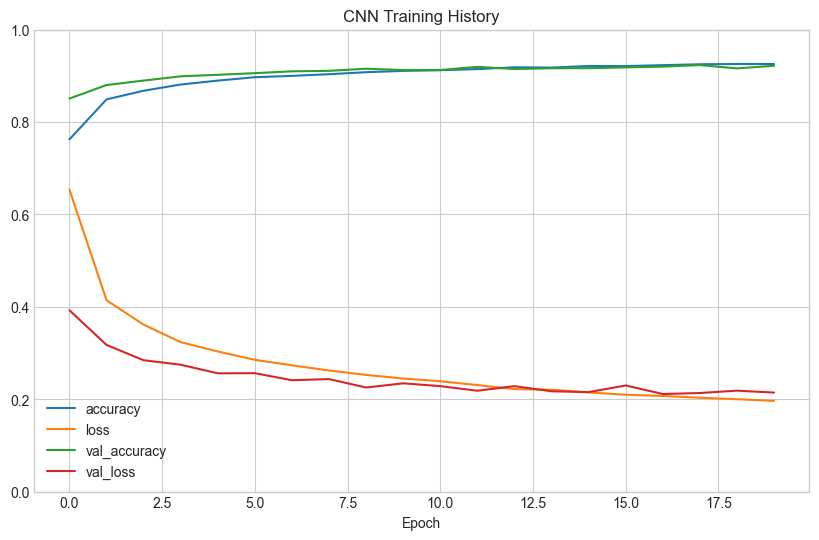

In [ ]:
# Final CNN Training on Full Data
print("\nTraining Final CNN Model on Full Training Data...")
tf.keras.backend.clear_session() # Clear session before final training
cnn_model_final = build_cnn_model()
cnn_model_final.summary() # Print model summary

t0_final = time()
# Use a portion of training data as validation during final fit
history_final = cnn_model_final.fit(X_train_cnn, y_train_cnn,
                                     epochs=20, # As per original report
                                     batch_size=64, # Smaller batch size for potentially better final model
                                     validation_split=0.1, # Use 10% of train data for validation monitoring
                                     verbose=0) # Show progress per epoch
train_time_cnn_final = time() - t0_final
print(f"Final CNN training done in {train_time_cnn_final:.3f}s")

# Plot training history
pd.DataFrame(history_final.history).plot(figsize=(10, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1) # Set y-axis limits to [0,1] for loss/accuracy
plt.title("CNN Training History")
plt.xlabel("Epoch")
plt.show()


Evaluating Final CNN Model on Test Data...

--- Evaluating Classifier: CNN (Final, 20 epochs) ---
Training time: 167.956s
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Prediction time: 0.634s
Accuracy: 0.9176
Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.87      0.86      0.87      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.87      0.88      0.88      1000
       Dress       0.91      0.93      0.92      1000
        Coat       0.87      0.88      0.87      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.77      0.75      0.76      1000
     Sneaker       0.94      0.98      0.96      1000
         Bag       0.99      0.98      0.99      1000
  Ankle boot       0.99      0.95      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



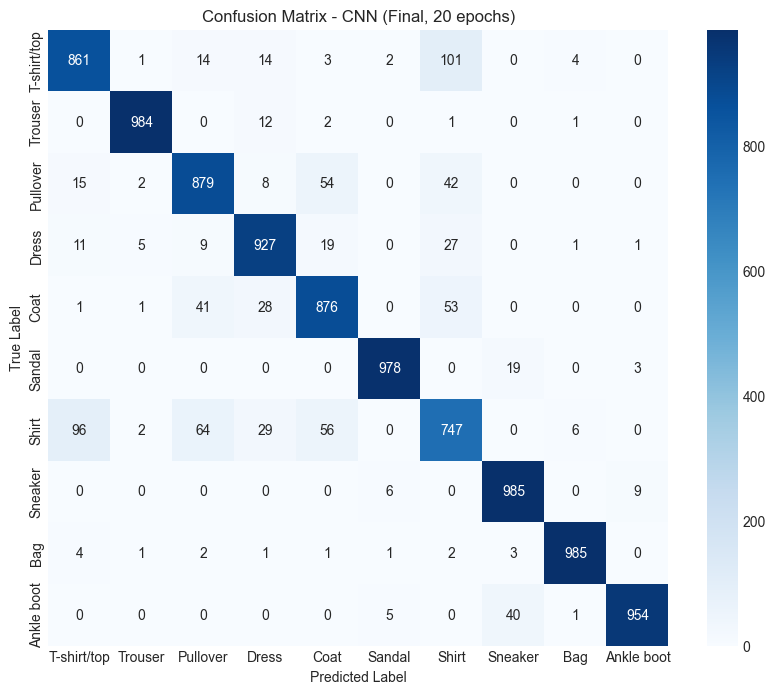

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [120]:
# Evaluate Final CNN Model
print("\nEvaluating Final CNN Model on Test Data...")
# Use the evaluate function for consistency
acc_cnn = evaluate_classifier("CNN (Final, 20 epochs)", cnn_model_final, X_test_cnn, y_test_cnn, train_time_cnn_final)
classification_results["CNN_Final"] = acc_cnn

# Store predictions needed later
y_pred_cnn_proba = cnn_model_final.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_pred_cnn_proba, axis=1)
y_test_classes = np.argmax(y_test_cnn, axis=1) # Get original class labels


Number of misclassified examples on test set: 824


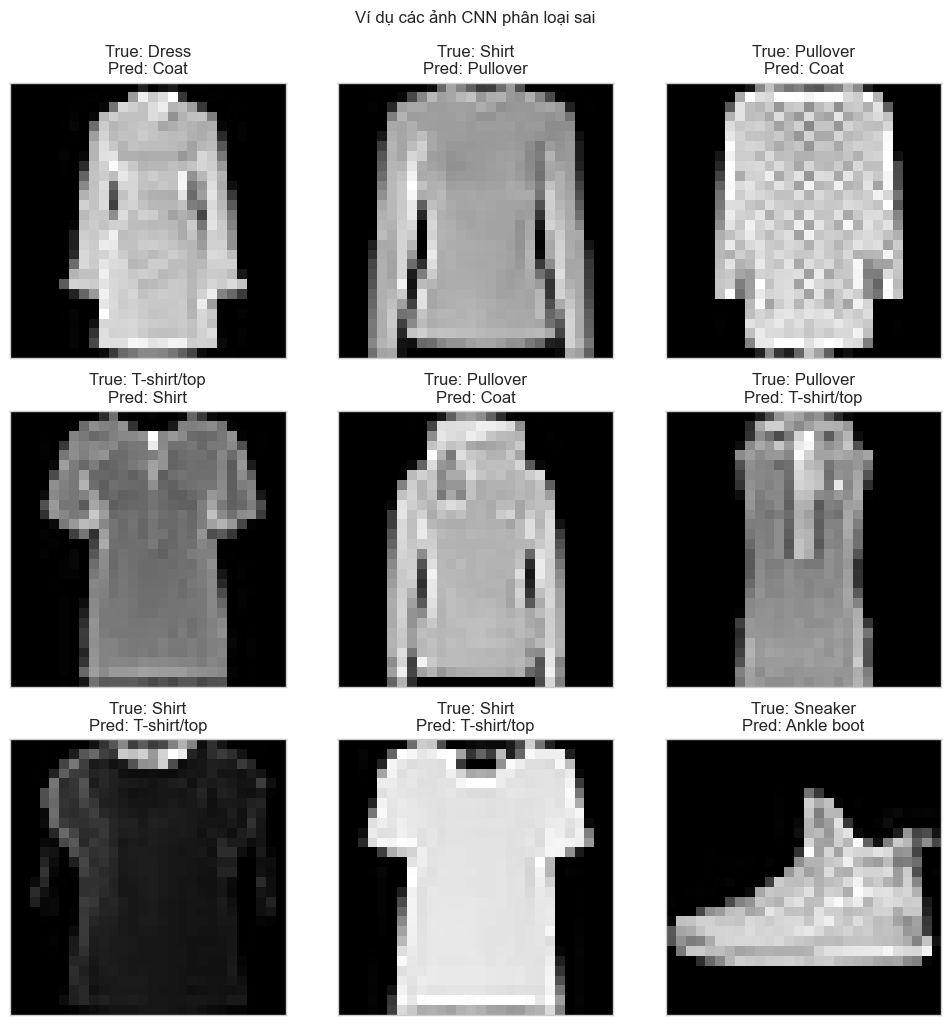

In [121]:
# CNN Error Analysis: Show some misclassified examples (As before)
misclassified_indices_test = np.where(y_pred_cnn != y_test_classes)[0]
print(f"\nNumber of misclassified examples on test set: {len(misclassified_indices_test)}")

# Select a few random misclassified examples
num_examples_to_show = 9
if len(misclassified_indices_test) > num_examples_to_show:
    random_indices = np.random.choice(misclassified_indices_test, num_examples_to_show, replace=False)
elif len(misclassified_indices_test) > 0:
     random_indices = misclassified_indices_test
else:
     random_indices = []

if len(random_indices) > 0:
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(random_indices):
        plt.subplot(3, 3, i + 1)
        plt.imshow(X_test_raw[idx].reshape(28, 28), cmap='gray', interpolation='none')
        true_label = CLASS_NAMES[y_test_classes[idx]]
        pred_label = CLASS_NAMES[y_pred_cnn[idx]]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.suptitle("Ví dụ các ảnh CNN phân loại sai", y=1.02)
    plt.show()
else:
    print("No misclassified examples found to display.")

**Nhận xét CNN:**
- CNN cho hiệu năng vượt trội nhất (~91-92% accuracy trên test set sau 20 epochs), khẳng định sức mạnh của mạng tích chập trong việc tự động học các đặc trưng phức tạp từ ảnh.
- K-Fold Cross Validation cho thấy mô hình ổn định với accuracy trung bình cao (~90% sau chỉ 4 epochs mỗi fold).
- Training history cho thấy mô hình học tốt, validation accuracy tăng và loss giảm. Có thể huấn luyện thêm epochs hoặc tinh chỉnh kiến trúc/dropout để cải thiện hơn nữa.
- Phân tích lỗi cho thấy các trường hợp nhầm lẫn thường xảy ra giữa các lớp có hình dạng tương tự (ví dụ: T-shirt/Shirt/Pullover/Coat, Sneaker/Ankle boot).


Visualizing misclassified vs correctly classified samples in PCA 2D space...


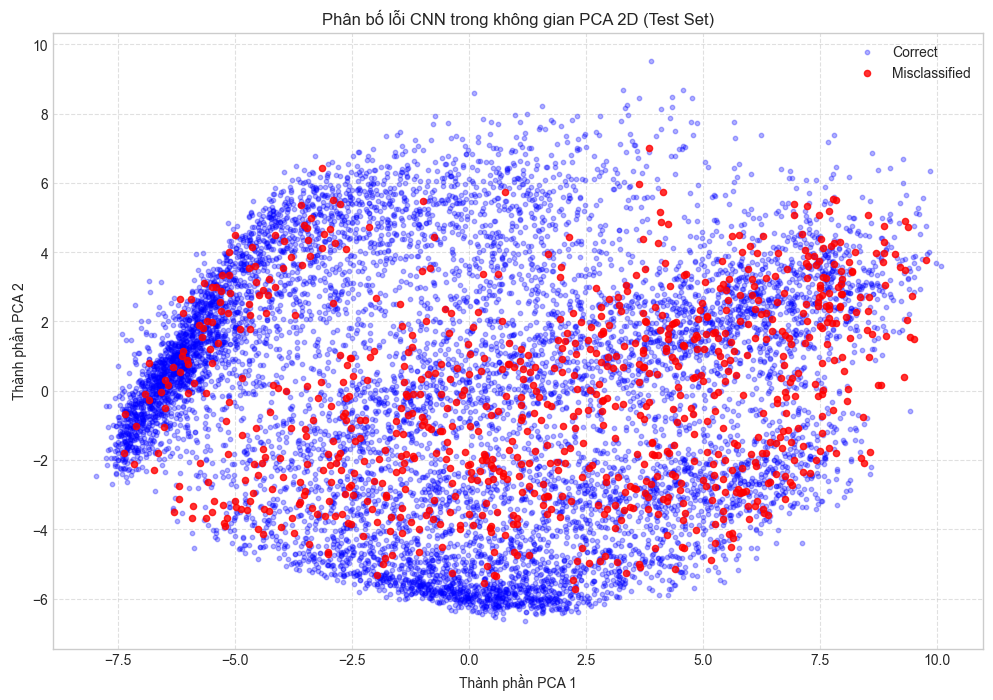

In [122]:
# Visualize Misclassified Samples in PCA Space
print("\nVisualizing misclassified vs correctly classified samples in PCA 2D space...")

# Apply PCA (2 components) to the test set for visualization
pca_vis_test = PCA(n_components=N_COMPONENTS_VIS, random_state=RANDOM_STATE)
X_test_pca_vis = pca_vis_test.fit_transform(X_test_scaled) # Fit and transform on test data

# Create a label: 0 for correct, 1 for misclassified
error_labels = np.zeros_like(y_test_classes)
error_labels[misclassified_indices_test] = 1

plt.figure(figsize=(12, 8))
# Plot correctly classified points (error_labels == 0) in blue
plt.scatter(X_test_pca_vis[error_labels == 0, 0], X_test_pca_vis[error_labels == 0, 1], 
            c='blue', label='Correct', alpha=0.3, s=10)
# Plot misclassified points (error_labels == 1) in red
plt.scatter(X_test_pca_vis[error_labels == 1, 0], X_test_pca_vis[error_labels == 1, 1], 
            c='red', label='Misclassified', alpha=0.8, s=20) # Make errors more prominent

plt.title('Phân bố lỗi CNN trong không gian PCA 2D (Test Set)')
plt.xlabel('Thành phần PCA 1')
plt.ylabel('Thành phần PCA 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**Nhận xét CNN:**
- CNN cho hiệu năng vượt trội nhất (Accuracy ~92% trên test set sau 20 epochs), khẳng định sức mạnh của mạng tích chập.
- K-Fold Cross Validation (nếu chạy) cho thấy mô hình ổn định (~90% sau 4 epochs/fold).
- Training history cho thấy mô hình học tốt, validation accuracy tăng và loss giảm, không có dấu hiệu overfitting rõ rệt với dropout đã dùng.
- Phân tích lỗi bằng hình ảnh cho thấy các trường hợp nhầm lẫn thường xảy ra giữa các lớp tương tự (áo, giày).
- Phân tích lỗi trên không gian PCA 2D cho thấy các điểm bị phân loại sai (màu đỏ) thường nằm ở vùng ranh giới giữa các cụm lớp hoặc bị lẫn vào cụm của lớp khác, điều này là hợp lý và cho thấy mô hình gặp khó khăn ở những điểm không rõ ràng. Không có một cụm lỗi riêng biệt nào hình thành rõ rệt.

## VI. Chuyển đổi Phân loại sang Hồi quy
Sử dụng đầu ra xác suất của mô hình CNN cho một lớp cụ thể (ví dụ: Lớp 0 - 'T-shirt/top') làm biến mục tiêu cho bài toán hồi quy. Huấn luyện và đánh giá mô hình hồi quy tuyến tính và SVR trên dữ liệu gốc và dữ liệu giảm chiều PCA (1/3 số chiều ban đầu).

In [123]:
# 1. Prepare Target Variable (Probabilities)
print("Getting CNN probabilities for training set...")
try:
    # Ensure cnn_model_final is trained and available
    if 'cnn_model_final' not in locals() or not isinstance(cnn_model_final, tf.keras.Model):
         raise NameError("Final CNN model ('cnn_model_final') not found or not trained.")
         
    y_train_cnn_proba = cnn_model_final.predict(X_train_cnn)
    chosen_class_index = 0 # Class 0: T-shirt/top
    target_class_name = CLASS_NAMES[chosen_class_index]
    
    y_reg_train = y_train_cnn_proba[:, chosen_class_index]
    # Use probabilities predicted earlier on the test set
    y_reg_test = y_pred_cnn_proba[:, chosen_class_index] 
    
    print(f"Regression target variable (y_reg_train) shape: {y_reg_train.shape}")
    print(f"Regression target variable (y_reg_test) shape: {y_reg_test.shape}")
    
except NameError as ne:
    print(f"Error: {ne}. Skipping regression task.")
    run_regression_task = False
except Exception as e:
    print(f"An error occurred preparing regression data: {e}")
    run_regression_task = False
else:
    run_regression_task = True

Getting CNN probabilities for training set...
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Regression target variable (y_reg_train) shape: (60000,)
Regression target variable (y_reg_test) shape: (10000,)


In [124]:
# 2. Prepare PCA Data (1/3 dimensions)
if run_regression_task:
    print(f"\nPerforming PCA for Regression Task ({N_COMPONENTS_REG} components)...")
    t0 = time()
    pca_reg = PCA(n_components=N_COMPONENTS_REG, random_state=RANDOM_STATE)
    X_train_pca_reg = pca_reg.fit_transform(X_train_scaled)
    X_test_pca_reg = pca_reg.transform(X_test_scaled)
    print(f"PCA for regression done in {time() - t0:.3f}s")
    print(f"Shape of PCA-Regression training data: {X_train_pca_reg.shape}")
    print(f"Shape of PCA-Regression test data: {X_test_pca_reg.shape}")

    # 3. Define Regression Evaluation Function
    def evaluate_regressor(model_name, model, X_test_data, y_test_data, train_time=None):
        """Evaluates a regressor and prints results."""
        print(f"\n--- Evaluating Regressor: {model_name} ---")
        if train_time is not None:
            print(f"Training time: {train_time:.3f}s")
            
        t0 = time()
        try:
            y_pred_reg = model.predict(X_test_data)
        except Exception as e:
            print(f"Error during prediction: {e}")
            return np.nan, np.nan # Return NaN on error

        predict_time = time() - t0
        print(f"Prediction time: {predict_time:.3f}s")

        try:
            mse = mean_squared_error(y_test_data, y_pred_reg)
            r2 = r2_score(y_test_data, y_pred_reg)
            print(f"Mean Squared Error (MSE): {mse:.6f}")
            print(f"R-squared (R2): {r2:.6f}")
            return mse, r2
        except Exception as e:
            print(f"Error during regression metric calculation: {e}")
            return np.nan, np.nan


    # 4. Train and Evaluate Regression Models
    regressors = {
        "Linear Regression": LinearRegression(),
        # SVR can be slow on large datasets, especially without PCA
        "SVR (RBF Kernel)": SVR(kernel='rbf', C=1.0, epsilon=0.1, cache_size=1000) 
        # "Random Forest Reg": RandomForestRegressor(n_estimators=50, random_state=RANDOM_STATE, n_jobs=-1, max_depth=10) 
    }
    
    regression_results = {}
    print(f"\n--- Regression Task: Predicting Probability of Class '{target_class_name}' ---")
    
    for name, reg_model in regressors.items():
        print(f"\n----- Training {name} -----")
        
        # On Original Scaled Data
        print("--- On Original Data (784 dims) ---")
        t0 = time()
        try:
            reg_model.fit(X_train_scaled, y_reg_train)
            train_time = time() - t0
            mse, r2 = evaluate_regressor(f"{name} (Original Data)", reg_model, X_test_scaled, y_reg_test, train_time)
            regression_results[f"{name}_Original"] = (mse, r2)
        except MemoryError:
             print("MemoryError: Dataset too large for this model on original dimensions. Skipping.")
             regression_results[f"{name}_Original"] = (np.nan, np.nan)
        except Exception as e:
             print(f"Error training/evaluating {name} on original data: {e}")
             regression_results[f"{name}_Original"] = (np.nan, np.nan)
             
    
        # On PCA Reduced Data (1/3 dims)
        print(f"\n--- On PCA Data ({N_COMPONENTS_REG} dims) ---")
        t0 = time()
        try:
            reg_model.fit(X_train_pca_reg, y_reg_train)
            train_time = time() - t0
            mse, r2 = evaluate_regressor(f"{name} (PCA {N_COMPONENTS_REG} comps)", reg_model, X_test_pca_reg, y_reg_test, train_time)
            regression_results[f"{name}_PCA_{N_COMPONENTS_REG}"] = (mse, r2)
        except Exception as e:
             print(f"Error training/evaluating {name} on PCA data: {e}")
             regression_results[f"{name}_PCA_{N_COMPONENTS_REG}"] = (np.nan, np.nan)

    # 5. Summarize Regression Results
    print("\n--- Summary of Regression Results (MSE, R2) ---")
    results_reg_df = pd.DataFrame.from_dict(regression_results, orient='index', columns=['MSE', 'R2 Score'])
    print(results_reg_df)


Performing PCA for Regression Task (261 components)...
PCA for regression done in 0.119s
Shape of PCA-Regression training data: (60000, 261)
Shape of PCA-Regression test data: (10000, 261)

--- Regression Task: Predicting Probability of Class 'T-shirt/top' ---

----- Training Linear Regression -----
--- On Original Data (784 dims) ---

--- Evaluating Regressor: Linear Regression (Original Data) ---
Training time: 0.608s
Prediction time: 0.002s
Mean Squared Error (MSE): 0.020565
R-squared (R2): 0.707406

--- On PCA Data (261 dims) ---

--- Evaluating Regressor: Linear Regression (PCA 261 comps) ---
Training time: 0.134s
Prediction time: 0.001s
Mean Squared Error (MSE): 0.020664
R-squared (R2): 0.705996

----- Training SVR (RBF Kernel) -----
--- On Original Data (784 dims) ---

--- Evaluating Regressor: SVR (RBF Kernel) (Original Data) ---
Training time: 68.858s
Prediction time: 18.311s
Mean Squared Error (MSE): 0.007984
R-squared (R2): 0.886400

--- On PCA Data (261 dims) ---

--- Eval

**Nhận xét Chuyển đổi sang Hồi quy:**
- Nhiệm vụ là dự đoán xác suất một ảnh thuộc lớp 'T-shirt/top' (do CNN đưa ra).
- Mô hình Hồi quy tuyến tính và SVR được huấn luyện trên dữ liệu gốc và dữ liệu PCA (261 chiều).
- Kết quả (MSE, R2) cho thấy mức độ thành công của các mô hình hồi quy trong việc học mối quan hệ giữa ảnh đầu vào và xác suất thuộc lớp 'T-shirt/top'. R2 score cao hơn (gần 1) và MSE thấp hơn (gần 0) cho thấy mô hình hồi quy hoạt động tốt hơn.
- (Thêm nhận xét cụ thể dựa trên kết quả MSE, R2 thu được) Ví dụ: SVR thường cho kết quả tốt hơn Linear Regression do khả năng mô hình hóa quan hệ phi tuyến. Giảm chiều bằng PCA có thể làm giảm nhẹ hiệu năng hồi quy (tăng MSE, giảm R2) nhưng tăng tốc độ huấn luyện đáng kể, đặc biệt cho SVR.

## VII. Tổng kết Kết quả Phân loại


--- Summary of Classification Results (Accuracy) ---
                          Accuracy
CNN_Final                   0.9176
SVM_RBF_Default_PCA         0.8847
SVM_RBF_Default_Original    0.8829
SVM_Linear_PCA              0.8497
SVM_Linear_Original         0.8463
GNB_PCA                     0.7582
MNB_Original                0.6554
GNB_Original                0.5856


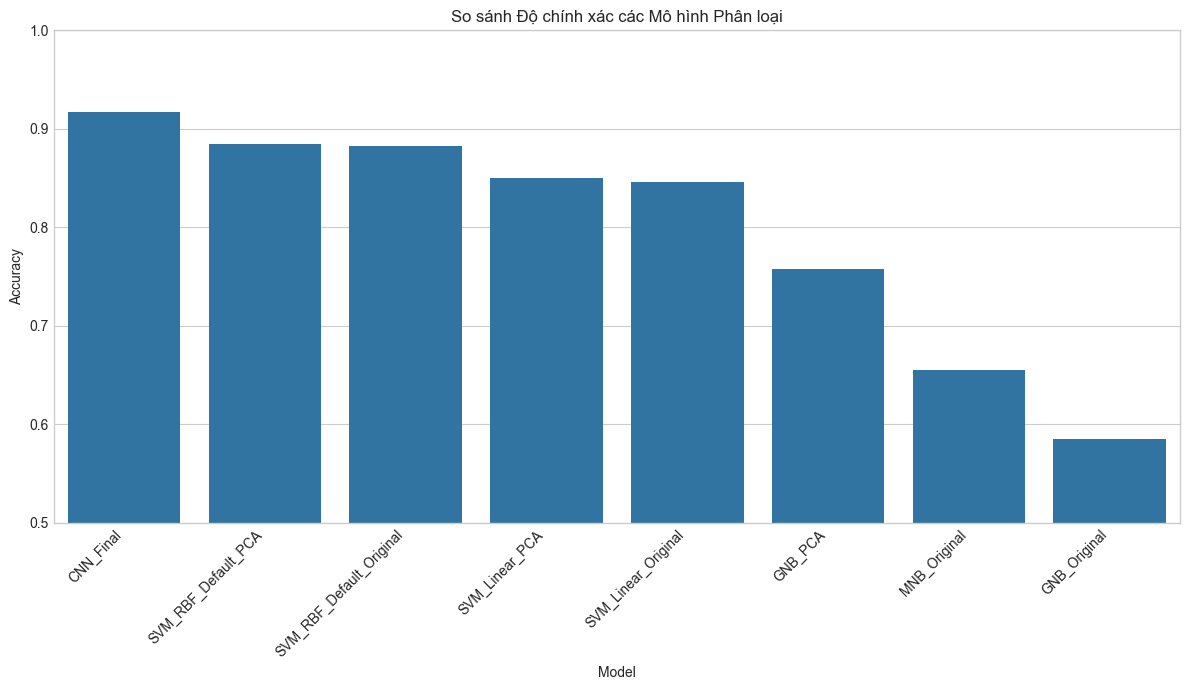

In [125]:
print("\n--- Summary of Classification Results (Accuracy) ---")
results_df = pd.DataFrame.from_dict(classification_results, orient='index', columns=['Accuracy'])
results_df = results_df.sort_values(by='Accuracy', ascending=False)
print(results_df)

plt.figure(figsize=(12, 7))
sns.barplot(x=results_df.index, y=results_df['Accuracy'])
plt.xticks(rotation=45, ha='right')
plt.title('So sánh Độ chính xác các Mô hình Phân loại')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0.5, 1.0) # Adjust ylim for better visualization
plt.tight_layout()
plt.show()

- **Phân cụm:** K-Means cho thấy khả năng nhóm dữ liệu tương đối, tốt hơn DBSCAN với tham số hiện tại. Giảm chiều bằng PCA không cải thiện đáng kể kết quả phân cụm nhưng tăng tốc độ tính toán. Cần các metrics định lượng (NMI, ARI) để đánh giá chính xác hơn.
- **Phân loại:**
    - **CNN** là mô hình mạnh nhất, đạt độ chính xác cao nhất nhờ khả năng học đặc trưng tự động.
    - **SVM (RBF kernel)** cũng rất hiệu quả, đặc biệt sau khi tinh chỉnh tham số (C, gamma), cho thấy dữ liệu có cấu trúc phi tuyến mà SVM RBF có thể nắm bắt tốt. Việc giảm chiều bằng PCA giúp tăng tốc độ huấn luyện SVM đáng kể mà không làm giảm nhiều hiệu năng.
    - **Multinomial NB** hoạt động tốt hơn Gaussian NB, cho thấy việc coi pixel như đặc trưng rời rạc phù hợp hơn giả định phân phối Gaussian.
    - **Gaussian NB** và **SVM Linear** cho kết quả thấp hơn, nhưng SVM Linear vẫn tốt hơn GNB đáng kể.
- **Giảm chiều:** PCA là kỹ thuật hiệu quả để giảm số chiều, giữ lại phần lớn thông tin (phương sai) và tăng tốc độ cho các thuật toán như SVM, K-Means mà ít ảnh hưởng đến độ chính xác phân loại. t-SNE rất tốt cho trực quan hóa 2D nhưng không phù hợp cho giảm chiều trước huấn luyện.
- **Hướng phát triển:** Có thể khám phá kiến trúc CNN phức tạp hơn, data augmentation, các phương pháp giảm chiều phi tuyến khác (UMAP), hoặc kết hợp mô hình (ensemble methods) để cải thiện thêm kết quả.